In [63]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

from sklearn import set_config

set_config(transform_output="pandas")

In [64]:
df_customer = pd.read_csv("data/olist_customers_dataset.csv")
df_geoloc = pd.read_csv("data/olist_geolocation_dataset.csv")
df_order_item = pd.read_csv("data/olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_order_review = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_order_list = pd.read_csv("data/olist_orders_dataset.csv")
df_product_list = pd.read_csv("data/olist_products_dataset.csv")
df_seller_list = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name = pd.read_csv("data/product_category_name_translation.csv")


In [90]:
# Fusionner les données pour obtenir les noms de catégorie de produit par client
df_merged = pd.merge(df_customer, df_order_list, on='customer_id')
df_merged = pd.merge(df_merged, df_order_payments[['order_id', 'payment_type', 'payment_value']], on='order_id')
df_merged = pd.merge(df_merged, df_order_review[['order_id', 'review_score']], on='order_id')
df_merged = pd.merge(df_merged, df_order_item[['order_id', 'product_id']], on='order_id')
df_merged = pd.merge(df_merged, df_product_list[['product_id', 'product_category_name']], on='product_id')
df_merged['product_category_name'] = df_merged['product_category_name'].astype(str) # convertir les valeurs en chaînes de caractères

# Calculer la durée moyenne de livraison pour chaque client
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['delivery_time'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days
mean_delivery_time = df_merged.groupby('customer_id')['delivery_time'].mean()

# Calculer le score de revue moyen pour chaque client
mean_review_score = df_merged.groupby('customer_id')['review_score'].mean()

# Trouver le type de paiement le plus courant pour chaque client
most_common_payment_type = df_merged.groupby('customer_id')['payment_type'].agg(lambda x: x.value_counts().index[0])

# Trouver la ville pour chaque client
city = df_merged.groupby('customer_id')['customer_city'].agg(lambda x: x.value_counts().index[0])

# Calculer le prix moyen par commande pour chaque client
mean_order_price = df_merged.groupby('order_id')['payment_value'].mean()
mean_order_price = df_merged.groupby('customer_id')['order_id'].apply(lambda x: mean_order_price[x].mean())

# Calculer le nombre de commandes moyen par client
mean_order_count = df_merged.groupby('customer_id')['order_id'].nunique()

# Obtenir les noms de catégorie de produit pour chaque client
category_names = df_merged.groupby('customer_id')['product_category_name'].apply(lambda x: ', '.join(x)).reset_index()

# Fusionner tous les résultats dans le dataframe final
df_final = pd.merge(mean_delivery_time, mean_review_score, on='customer_id')
df_final = pd.merge(df_final, most_common_payment_type, on='customer_id')
df_final = pd.merge(df_final, city, on='customer_id')
df_final = pd.merge(df_final, mean_order_price, on='customer_id')
df_final = pd.merge(df_final, mean_order_count, on='customer_id')
df_final = pd.merge(df_final, category_names, on='customer_id')

# Renommer les colonnes
df_final.columns = ['customer_id','mean_delivery_time', 'mean_review_score', 'most_common_payment_type', 'city', 'mean_order_price', 'mean_order_count','product_category_name']

In [99]:
df_final

customer_id  mean_delivery_time  \
0      00012a2ce6f8dcda20d059ce98491703                13.0   
1      000161a058600d5901f007fab4c27140                 9.0   
2      0001fd6190edaaf884bcaf3d49edf079                 5.0   
3      0002414f95344307404f0ace7a26f1d5                28.0   
4      000379cdec625522490c315e70c7a9fb                11.0   
...                                 ...                 ...   
97911  fffcb937e9dd47a13f05ecb8290f4d3e                 4.0   
97912  fffecc9f79fd8c764f843e9951b11341                12.0   
97913  fffeda5b6d849fbd39689bb92087f431                17.0   
97914  ffff42319e9b2d713724ae527742af25                 5.0   
97915  ffffa3172527f765de70084a7e53aae8                12.0   

       mean_review_score most_common_payment_type             city  \
0                    1.0              credit_card           osasco   
1                    4.0              credit_card      itapecerica   
2                    5.0              credit_card     nova venecia   
3                    5.0                   boleto         mendonca   
4                    4.0                   boleto        sao paulo   
...                  ...                      ...              ...   
97911                5.0              credit_card        sao paulo   
97912                3.0                  voucher           parobe   
97913                4.0              credit_card   rio de janeiro   
97914                5.0              credit_card  taboao da serra   
97915                5.0              credit_card          alfenas   

       mean_order_price  mean_order_count  \
0                114.74                 1   
1                 67.41                 1   
2                195.42                 1   
3                179.35                 1   
4                107.01                 1   
...                 ...               ...   
97911             91.91                 1   
97912             27.12                 1   
97913             63.13                 1   
97914            214.13                 1   
97915             45.50                 1   

                                   product_category_name  
0                                             brinquedos  
1                                           beleza_saude  
2                                                  bebes  
3                                             cool_stuff  
4                                        cama_mesa_banho  
...                                                  ...  
97911                             livros_interesse_geral  
97912  cama_mesa_banho, cama_mesa_banho, cama_mesa_banho  
97913                                          telefonia  
97914                                    cama_mesa_banho  
97915                 moveis_decoracao, moveis_decoracao  

[97916 rows x 8 columns]

In [108]:
df_finals = df_final.copy()

In [109]:
df_finals

customer_id  mean_delivery_time  \
0      00012a2ce6f8dcda20d059ce98491703                13.0   
1      000161a058600d5901f007fab4c27140                 9.0   
2      0001fd6190edaaf884bcaf3d49edf079                 5.0   
3      0002414f95344307404f0ace7a26f1d5                28.0   
4      000379cdec625522490c315e70c7a9fb                11.0   
...                                 ...                 ...   
97911  fffcb937e9dd47a13f05ecb8290f4d3e                 4.0   
97912  fffecc9f79fd8c764f843e9951b11341                12.0   
97913  fffeda5b6d849fbd39689bb92087f431                17.0   
97914  ffff42319e9b2d713724ae527742af25                 5.0   
97915  ffffa3172527f765de70084a7e53aae8                12.0   

       mean_review_score most_common_payment_type             city  \
0                    1.0              credit_card           osasco   
1                    4.0              credit_card      itapecerica   
2                    5.0              credit_card     nova venecia   
3                    5.0                   boleto         mendonca   
4                    4.0                   boleto        sao paulo   
...                  ...                      ...              ...   
97911                5.0              credit_card        sao paulo   
97912                3.0                  voucher           parobe   
97913                4.0              credit_card   rio de janeiro   
97914                5.0              credit_card  taboao da serra   
97915                5.0              credit_card          alfenas   

       mean_order_price  mean_order_count  \
0                114.74                 1   
1                 67.41                 1   
2                195.42                 1   
3                179.35                 1   
4                107.01                 1   
...                 ...               ...   
97911             91.91                 1   
97912             27.12                 1   
97913             63.13                 1   
97914            214.13                 1   
97915             45.50                 1   

                                   product_category_name  
0                                             brinquedos  
1                                           beleza_saude  
2                                                  bebes  
3                                             cool_stuff  
4                                        cama_mesa_banho  
...                                                  ...  
97911                             livros_interesse_geral  
97912  cama_mesa_banho, cama_mesa_banho, cama_mesa_banho  
97913                                          telefonia  
97914                                    cama_mesa_banho  
97915                 moveis_decoracao, moveis_decoracao  

[97916 rows x 8 columns]

In [110]:
from sklearn.preprocessing import OneHotEncoder

# Instancier l'objet OneHotEncoder avec min_frequency
encoder = OneHotEncoder(handle_unknown='error', sparse_output=False, min_frequency=0.05)

# Encoder les colonnes 'product_category_name', 'most_common_payment_type', et 'city'
columns_to_encode = ['product_category_name', 'most_common_payment_type', 'city']
encoded_features = encoder.fit_transform(df_finals[columns_to_encode])

# Générer les noms de colonnes pour le DataFrame d'encodage
encoded_columns = encoder.get_feature_names_out(columns_to_encode)

# Créer un DataFrame à partir des résultats de l'encodage
df_encoded = pd.DataFrame(encoded_features, columns=encoded_columns)

# Concaténer le DataFrame d'encodage avec le DataFrame original
df_final_encoded = pd.concat([df_finals, df_encoded], axis=1)

# Supprimer les colonnes originales encodées
df_final_encoded.drop(columns_to_encode, axis=1, inplace=True)



In [111]:
df_final_encoded

customer_id  mean_delivery_time  \
0      00012a2ce6f8dcda20d059ce98491703                13.0   
1      000161a058600d5901f007fab4c27140                 9.0   
2      0001fd6190edaaf884bcaf3d49edf079                 5.0   
3      0002414f95344307404f0ace7a26f1d5                28.0   
4      000379cdec625522490c315e70c7a9fb                11.0   
...                                 ...                 ...   
97911  fffcb937e9dd47a13f05ecb8290f4d3e                 4.0   
97912  fffecc9f79fd8c764f843e9951b11341                12.0   
97913  fffeda5b6d849fbd39689bb92087f431                17.0   
97914  ffff42319e9b2d713724ae527742af25                 5.0   
97915  ffffa3172527f765de70084a7e53aae8                12.0   

       mean_review_score  mean_order_price  mean_order_count  \
0                    1.0            114.74                 1   
1                    4.0             67.41                 1   
2                    5.0            195.42                 1   
3                    5.0            179.35                 1   
4                    4.0            107.01                 1   
...                  ...               ...               ...   
97911                5.0             91.91                 1   
97912                3.0             27.12                 1   
97913                4.0             63.13                 1   
97914                5.0            214.13                 1   
97915                5.0             45.50                 1   

       product_category_name_beleza_saude  \
0                                     0.0   
1                                     1.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
97911                                 0.0   
97912                                 0.0   
97913                                 0.0   
97914                                 0.0   
97915                                 0.0   

       product_category_name_cama_mesa_banho  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        1.0   
...                                      ...   
97911                                    0.0   
97912                                    0.0   
97913                                    0.0   
97914                                    1.0   
97915                                    0.0   

       product_category_name_esporte_lazer  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
97911                                  0.0   
97912                                  0.0   
97913                                  0.0   
97914                                  0.0   
97915                                  0.0   

       product_category_name_informatica_acessorios  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
97911                                           0.0   
97912                                           0.0   
97913                                           0.0   
97914                                           0.0   
97915                                           0.0   

       product_category_name_relogios_presentes  \
0                                           0.0   
1                                           0.0   
2                

<Axes: >

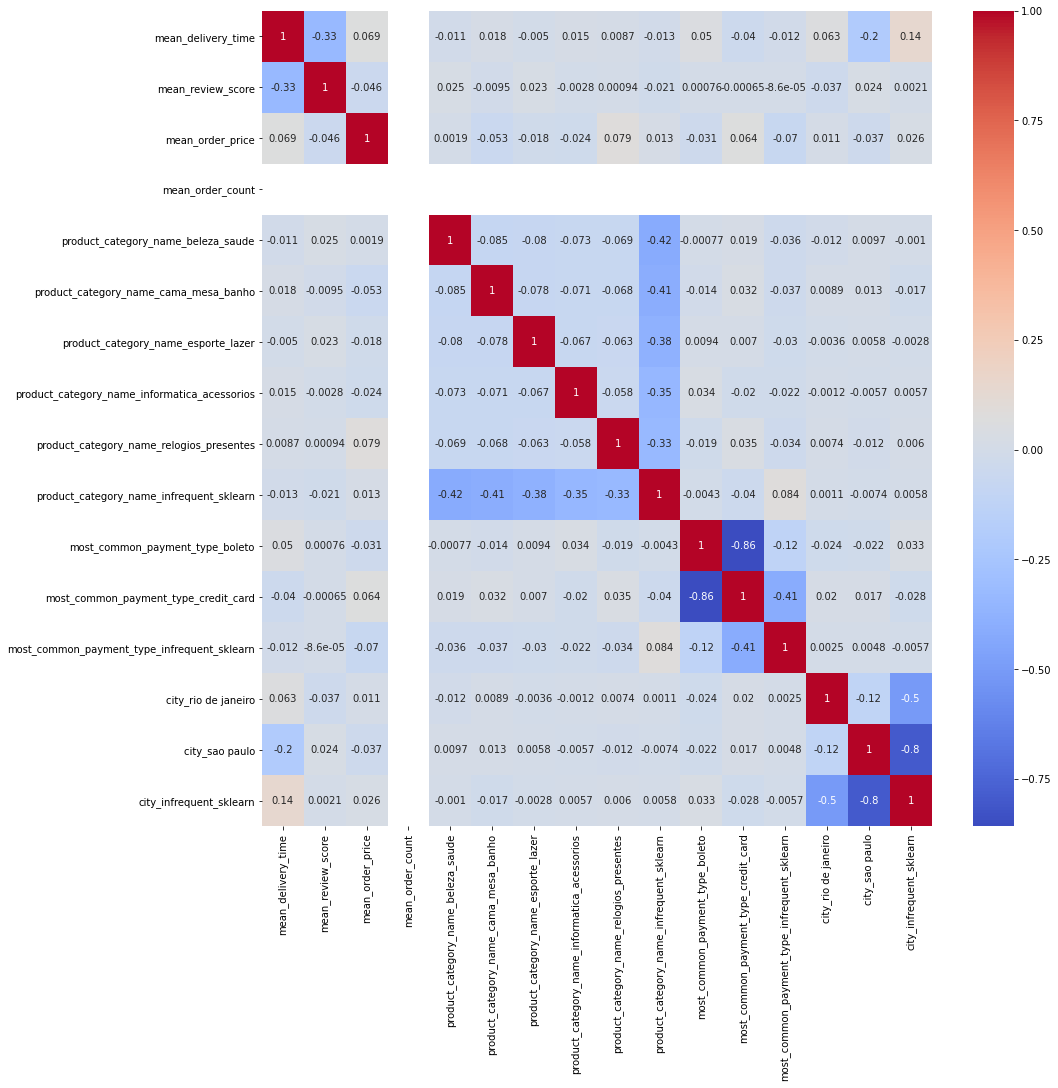

In [112]:
import seaborn as sns

# Créer une heatmap des corrélations
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_final_encoded.corr(), cmap='coolwarm', annot=True)

In [94]:
df_three.columns

Index(['product_category_name_beleza_saude',
       'product_category_name_cama_mesa_banho',
       'product_category_name_esporte_lazer',
       'product_category_name_informatica_acessorios',
       'product_category_name_relogios_presentes',
       'product_category_name_infrequent_sklearn'],
      dtype='object')

In [95]:
df_final_copy[['product_category_name_beleza_saude',
       'product_category_name_cama_mesa_banho',
       'product_category_name_esporte_lazer',
       'product_category_name_informatica_acessorios',
       'product_category_name_relogios_presentes',
       'product_category_name_infrequent_sklearn']] = df_three[['product_category_name_beleza_saude',
       'product_category_name_cama_mesa_banho',
       'product_category_name_esporte_lazer',
       'product_category_name_informatica_acessorios',
       'product_category_name_relogios_presentes',
       'product_category_name_infrequent_sklearn']]

In [ ]:
df_final_copy = df_final_copy.drop('other', axis=1)

In [96]:
df_final_copy

customer_id  mean_delivery_time  \
0      00012a2ce6f8dcda20d059ce98491703                13.0   
1      000161a058600d5901f007fab4c27140                 9.0   
2      0001fd6190edaaf884bcaf3d49edf079                 5.0   
3      0002414f95344307404f0ace7a26f1d5                28.0   
4      000379cdec625522490c315e70c7a9fb                11.0   
...                                 ...                 ...   
97911  fffcb937e9dd47a13f05ecb8290f4d3e                 4.0   
97912  fffecc9f79fd8c764f843e9951b11341                12.0   
97913  fffeda5b6d849fbd39689bb92087f431                17.0   
97914  ffff42319e9b2d713724ae527742af25                 5.0   
97915  ffffa3172527f765de70084a7e53aae8                12.0   

       mean_review_score most_common_payment_type             city  \
0                    1.0              credit_card           osasco   
1                    4.0              credit_card      itapecerica   
2                    5.0              credit_card     nova venecia   
3                    5.0                   boleto         mendonca   
4                    4.0                   boleto        sao paulo   
...                  ...                      ...              ...   
97911                5.0              credit_card        sao paulo   
97912                3.0                  voucher           parobe   
97913                4.0              credit_card   rio de janeiro   
97914                5.0              credit_card  taboao da serra   
97915                5.0              credit_card          alfenas   

       mean_order_price  mean_order_count  \
0                114.74                 1   
1                 67.41                 1   
2                195.42                 1   
3                179.35                 1   
4                107.01                 1   
...                 ...               ...   
97911             91.91                 1   
97912             27.12                 1   
97913             63.13                 1   
97914            214.13                 1   
97915             45.50                 1   

                                   product_category_name  \
0                                             brinquedos   
1                                           beleza_saude   
2                                                  bebes   
3                                             cool_stuff   
4                                        cama_mesa_banho   
...                                                  ...   
97911                             livros_interesse_geral   
97912  cama_mesa_banho, cama_mesa_banho, cama_mesa_banho   
97913                                          telefonia   
97914                                    cama_mesa_banho   
97915                 moveis_decoracao, moveis_decoracao   

       product_category_name_beleza_saude  \
0                                     0.0   
1                                     1.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
97911                                 0.0   
97912                                 0.0   
97913                                 0.0   
97914                                 0.0   
97915                                 0.0   

       product_category_name_cama_mesa_banho  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        1.0   
...                                      ...   
97911                                    0.0   
97912                                    0.0   
97913                                    0.0   
97914                                    1.0   
97915                                    0.0   

       product_category_name_esporte_lazer  \
0   

In [68]:
pourcentage_1 = df_one['product_category_name_agro_industria_e_comercio'].mean() * 100
print("Le pourcentage de 1 dans la colonne 'product_category_name_beleza_saude' est de {:.2f}%.".format(pourcentage_1))


Le pourcentage de 1 dans la colonne 'product_category_name_beleza_saude' est de 0.22%.


In [192]:
duplicates = df_order_list_price[df_order_list_price.duplicated()]
if duplicates.empty:
    print("Pas de doublons dans le dataframe")
else:
    print("Le dataframe contient des doublons")

Pas de doublons dans le dataframe


In [4]:
# Pour le dataframe df_customer
numeric_cols_customer = df_customer.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_geoloc
numeric_cols_geoloc = df_geoloc.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_order_item
numeric_cols_order_item = df_order_item.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_order_payments
numeric_cols_order_payments = df_order_payments.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_order_review
numeric_cols_order_review = df_order_review.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_order_list
numeric_cols_order_list = df_order_list.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_product_list
numeric_cols_product_list = df_product_list.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_seller_list
numeric_cols_seller_list = df_seller_list.select_dtypes(include=[np.number]).columns

# Pour le dataframe df_product_category_name
numeric_cols_product_category_name = df_product_category_name.select_dtypes(include=[np.number]).columns


In [5]:
numeric_cols_customer,numeric_cols_geoloc,numeric_cols_order_item,numeric_cols_order_payments,numeric_cols_order_review,numeric_cols_order_list,numeric_cols_product_list,numeric_cols_seller_list,numeric_cols_product_category_name

(Index(['customer_zip_code_prefix'], dtype='object'),
 Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'], dtype='object'),
 Index(['order_item_id', 'price', 'freight_value'], dtype='object'),
 Index(['payment_sequential', 'payment_installments', 'payment_value'], dtype='object'),
 Index(['review_score'], dtype='object'),
 Index([], dtype='object'),
 Index(['product_name_lenght', 'product_description_lenght',
        'product_photos_qty', 'product_weight_g', 'product_length_cm',
        'product_height_cm', 'product_width_cm'],
       dtype='object'),
 Index(['seller_zip_code_prefix'], dtype='object'),
 Index([], dtype='object'))

In [15]:
display(df_customer,
df_geoloc,
df_order_item,
df_order_payments,
df_order_review,
df_order_list, 
df_product_list, 
df_seller_list, 
df_product_category_name)

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

order_id  payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3       ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4       42fdf880ba16b47b59251dd489d4441a                   1  credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
0                          8          99.33  
1                          1          24.39  
2                          1          65.71  
3                          8         107.78  
4                          2         128.45  
...                      ...            ...  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58  

[103886 rows x 5 columns]

review_id                          order_id  \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
0                 4                  NaN   
1                 5                  NaN   
2                 5                  NaN   
3                 5                  NaN   
4                 5                  NaN   
...             ...                  ...   
99219             5                  NaN   
99220             5                  NaN   
99221             5                  NaN   
99222             4                  NaN   
99223             1                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2018-01-18 00:00:00   
1                                                    NaN  2018-03-10 00:00:00   
2                                                    NaN  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99219                                                NaN  2018-07-07 00:00:00   
99220                                                NaN  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                                NaN  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0         2018-01-18 21:46:59  
1         2018-03-11 03:05:13  
2         2018-02-18 14:36:24  
3         2017-04-21 22:02:06  
4         2018-03-02 10:26:53  
...                       ...  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49  

[99224 rows x 7 columns]

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     44.0                       276.0                 1.0   
2                     46.0                       250.0                 1.0   
3                     27.0                       261.0                 1.0   
4                     37.0                       402.0                 4.0   
...                    ...                         ...                 ...   
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                1000.0               30.0               18.0   
2                 154.0               18.0                9.0   
3                 371.0               26.0                4.0   
4                 625.0               20.0               17.0   
...                 ...                ...                ...   
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
0                  14.0  
1                  20.0  
2                  15.0  
3                  26.0  
4                  13.0  
...                 ...  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0  

[32951 rows x 9 columns]

seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

<AxesSubplot:>

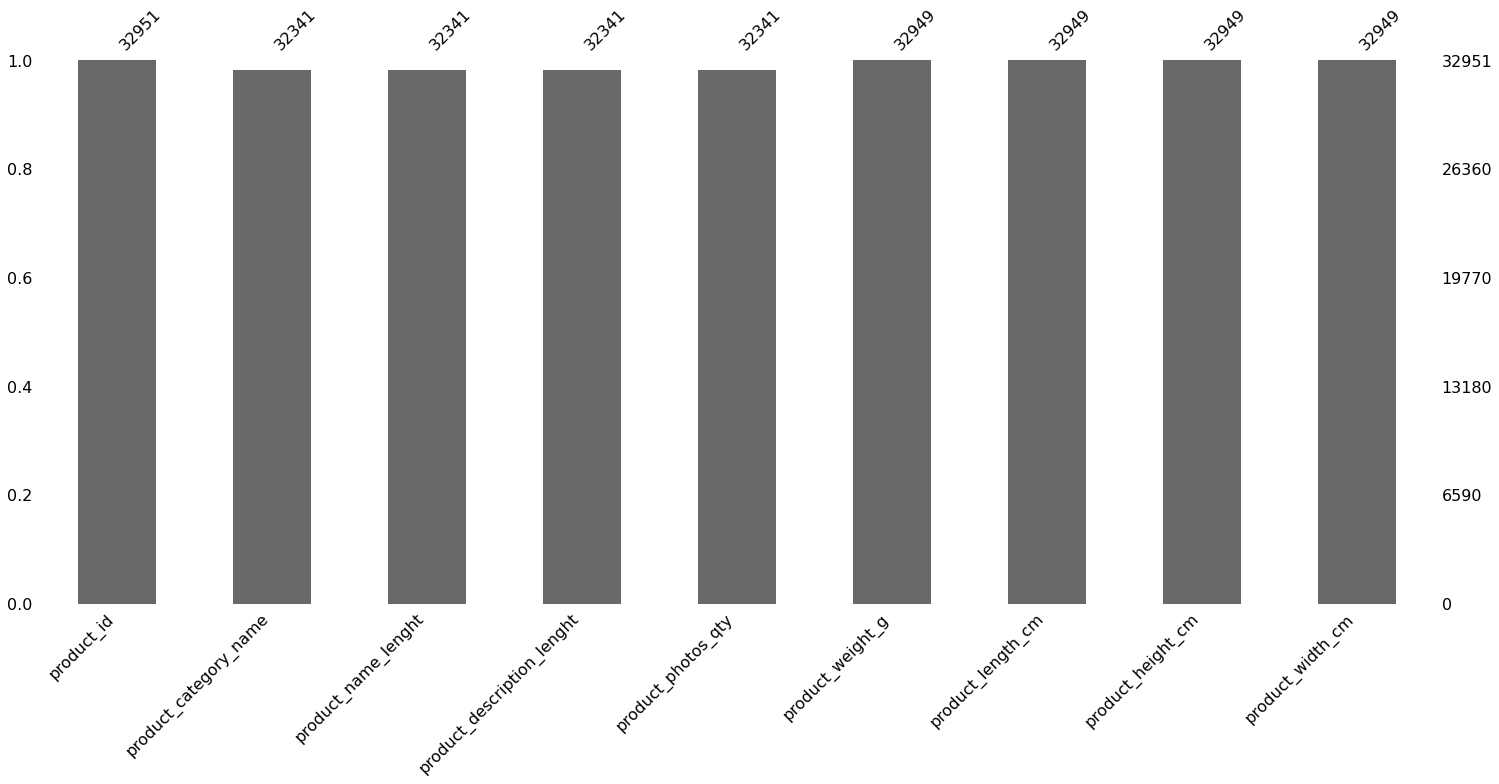

In [48]:
msno.bar(df_product_list)

In [22]:
df_customer.columns


Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [23]:
df_geoloc.columns


Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [24]:
df_order_item.columns


Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [44]:
df_order_payments.columns


Index(['order_id', 'payment_value'], dtype='object')

In [26]:
df_order_review.columns


Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [27]:
df_order_list.columns


Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [28]:
df_product_list.columns


Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [29]:
df_seller_list.columns


Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [30]:
df_product_category_name.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [31]:
df_order_list

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

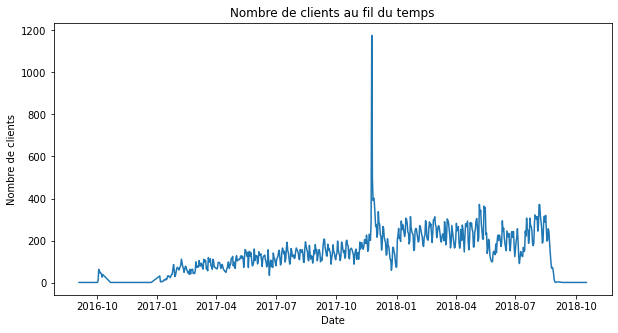

In [40]:
#est ce que les utilisateurs sont des plus en plus nombreux avec le temps ? 

df_order_list["date"] = df_order_list["order_purchase_timestamp"].dt.date

# Compter le nombre de clients par jour
customer_count = df_order_list.groupby("date")["customer_id"].nunique()

# Créer un graphique montrant l'évolution du nombre de clients au fil du temps
plt.figure(figsize=(10,5))

plt.plot(customer_count.index, customer_count.values)
plt.title("Nombre de clients au fil du temps")
plt.xlabel("Date")
plt.ylabel("Nombre de clients")
plt.show()


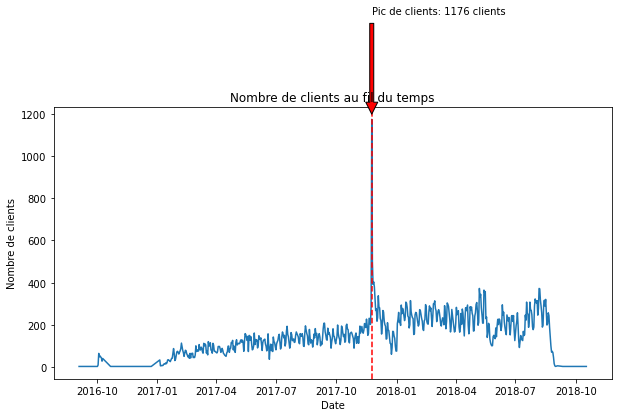

In [41]:
# Extraire la date (sans l'heure)
df_order_list['order_date'] = df_order_list['order_purchase_timestamp'].dt.date

# Compter le nombre de clients par jour
customer_count = df_order_list.groupby("order_date")["customer_id"].nunique()

# Trouver la date et le nombre de clients pour le pic
peak_date = customer_count.idxmax()
peak_count = customer_count.max()

# Créer un graphique montrant l'évolution du nombre de clients au fil du temps
plt.figure(figsize=(10,5))
plt.plot(customer_count.index, customer_count.values)
plt.title("Nombre de clients au fil du temps")
plt.xlabel("Date")
plt.ylabel("Nombre de clients")

# Ajouter une ligne verticale pour le pic
plt.axvline(x=peak_date, color='r', linestyle='--')

# Ajouter une annotation pour le pic
plt.annotate('Pic de clients: {} clients'.format(peak_count), xy=(peak_date, peak_count), xytext=(peak_date, peak_count+500), arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()


In [42]:
peak_date

datetime.date(2017, 11, 24)

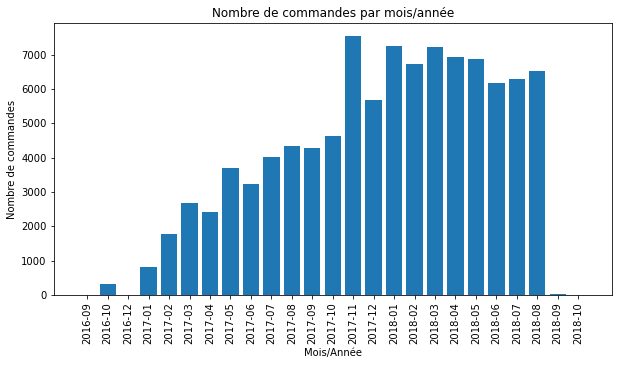

In [43]:
# Nombre de commande par mois simplifié

# Extraire le mois et l'année de chaque commande en une seule ligne
df_order_list['order_month'] = pd.to_datetime(df_order_list['order_purchase_timestamp']).dt.to_period('M')

# Compter le nombre de commandes pour chaque mois/année
orders_by_month = df_order_list['order_month'].value_counts().sort_index()

# Créer un graphique à barres pour visualiser le nombre de commandes pour chaque mois/année
plt.figure(figsize=(10,5))
plt.bar(orders_by_month.index.astype(str), orders_by_month.values)
plt.xlabel('Mois/Année')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par mois/année')
plt.xticks(rotation=90)
plt.show()


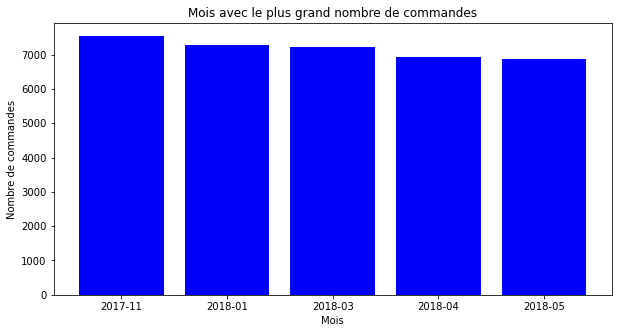

In [44]:
##Mois avec le plus de commande


# Extraction du mois et de l'année de chaque commande
df_order_list['month_year'] = df_order_list['order_purchase_timestamp'].dt.to_period('M')

# Comptage du nombre de commandes par mois
df_monthly_orders = df_order_list['month_year'].value_counts().sort_index()

# Récupération des mois ayant le plus grand nombre de commandes
top_months = df_monthly_orders.nlargest(5).index

# Filtre des données pour ne conserver que les mois avec le plus grand nombre de commandes
df_top_months = df_order_list[df_order_list['month_year'].isin(top_months)]

# Comptage du nombre de commandes par mois pour les mois sélectionnés
df_top_monthly_orders = df_top_months['month_year'].value_counts().sort_index()

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_top_monthly_orders.index.astype(str), df_top_monthly_orders.values, color='blue')

# Configuration des axes
ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de commandes')
ax.set_title('Mois avec le plus grand nombre de commandes')
plt.show()


Le montant moyen dépensé par commande est de 158.32 BRL


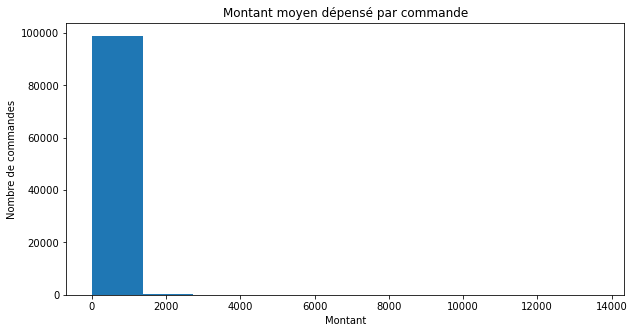

In [45]:
# Fusionner les dataframes sur la colonne "order_id"
df_merged = pd.merge(df_order_list, df_order_payments, on="order_id")

# Calculer le montant total par commande
df_merged["total_amount"] = df_merged["payment_value"]

# Grouper les commandes et calculer le montant moyen
avg_order_amount = df_merged.groupby("order_id")["total_amount"].mean().mean()

# Afficher le résultat
print("Le montant moyen dépensé par commande est de", round(avg_order_amount, 2), "BRL")

# Créer un graphique du montant moyen dépensé par commande
df_merged.groupby("order_id")["total_amount"].mean().plot(kind='hist', figsize=(10,5))
plt.title('Montant moyen dépensé par commande')
plt.xlabel('Montant')
plt.ylabel('Nombre de commandes')
plt.show()


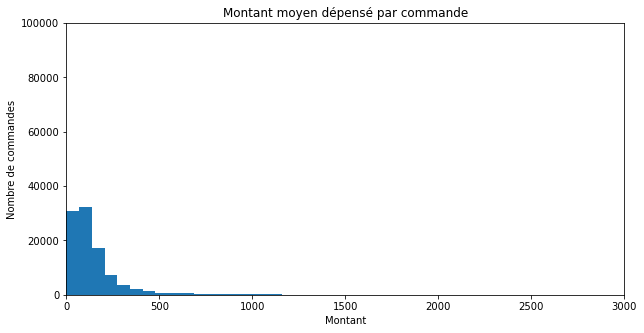

In [46]:
# Fusionner les dataframes sur la colonne "order_id"
df_merged = pd.merge(df_order_list, df_order_payments, on="order_id")

# Calculer le montant total par commande
df_merged["total_amount"] = df_merged["payment_value"]

# Grouper les commandes et calculer le montant moyen
avg_order_amount = df_merged.groupby("order_id")["total_amount"].mean().mean()

# Créer un graphique du montant moyen dépensé par commande
df_merged.groupby("order_id")["total_amount"].mean().plot(kind='hist', figsize=(10,5), bins=200)
plt.title('Montant moyen dépensé par commande')
plt.xlabel('Montant')
plt.ylabel('Nombre de commandes')
plt.xlim(0, 3000) # Ajuster la limite de l'axe X entre 0 et 3000
plt.ylim(0, 100000) # Ajuster la limite de l'axe Y pour mieux visualiser les données
plt.show()


In [ ]:
# Compter le nombre de commandes par client
df_order_count = df_order_list.groupby('customer_id').count()['order_id']

# Calculer la moyenne des commandes par client
avg_order_count = df_order_count.mean()

# Afficher le résultat
print("En moyenne, les clients commandent", round(avg_order_count, 2), "fois sur le site.")

# Créer un graphique de la distribution du nombre de commandes par client
df_order_count.plot(kind='hist', figsize=(10,5))
plt.title('Distribution du nombre de commandes par client')
plt.xlabel('Nombre de commandes')
plt.ylabel('Nombre de clients')
plt.show()



Les 10 catégories de produits les plus vendues sont :
 cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: product_category_name, dtype: int64


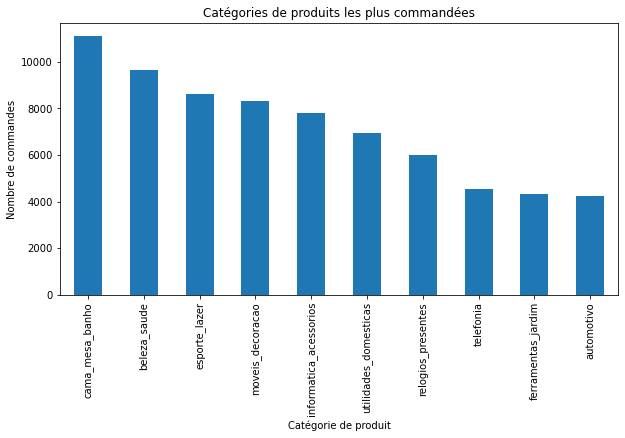

In [47]:
#category les plus commander
# Fusionner les dataframes sur la colonne "product_id"
df_merged = pd.merge(df_order_item, df_product_list, on="product_id")

# Compter le nombre de produits vendus par catégorie
category_counts = df_merged["product_category_name"].value_counts()

# Afficher les 10 catégories les plus vendues
top_categories = category_counts.nlargest(10)
print("Les 10 catégories de produits les plus vendues sont :\n", top_categories)

# Créer un graphique des catégories de produits les plus commandées
top_categories.plot(kind='bar', figsize=(10,5))
plt.title('Catégories de produits les plus commandées')
plt.xlabel('Catégorie de produit')
plt.ylabel('Nombre de commandes')
plt.show()


Les types de paiement les plus utilisés sont :
 credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64


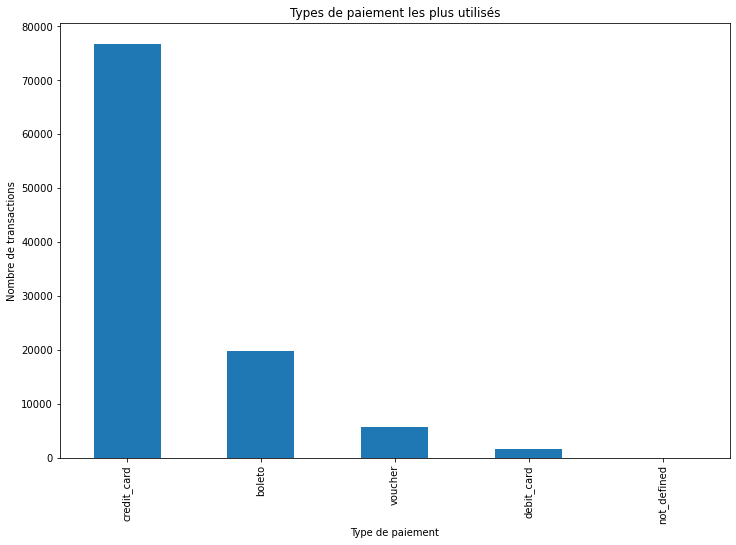

In [48]:
# Compter le nombre de transactions par type de paiement
payment_counts = df_order_payments['payment_type'].value_counts()

# Afficher les types de paiement les plus utilisés
print("Les types de paiement les plus utilisés sont :\n", payment_counts)

# Créer un graphique des types de paiement les plus utilisés
payment_counts.plot(kind='bar', figsize=(12,8))
plt.title('Types de paiement les plus utilisés')
plt.xlabel('Type de paiement')
plt.ylabel('Nombre de transactions')
plt.show()



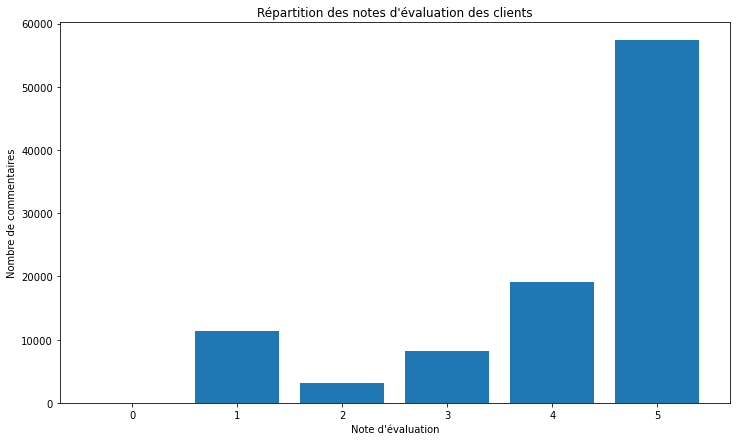

In [49]:

# Créer un histogramme des notes d'évaluation
plt.figure(figsize=(12,7))
plt.hist(df_order_review["review_score"], bins=[0,1,2,3,4,5,6], align='left', rwidth=0.8)
plt.xticks([0,1,2,3,4,5], ["0", "1", "2", "3", "4", "5"])
plt.xlabel("Note d'évaluation")
plt.ylabel("Nombre de commentaires")
plt.title("Répartition des notes d'évaluation des clients")
plt.show()


In [50]:
df_order_review.loc[df_order_review["review_score"]== 1]

review_id                          order_id  \
5      15197aa66ff4d0650b5434f1b46cda19  b18dcdf73be66366873cd26c5724d1dc   
19     373cbeecea8286a2b66c97b1b157ec46  583174fbe37d3d5f0d6661be3aad1786   
29     2c5e27fc178bde7ac173c9c62c31b070  0ce9a24111d850192a933fcaab6fbad3   
32     58044bca115705a48fe0e00a21390c54  68e55ca79d04a79f20d4bfc0146f4b66   
39     9fd59cd04b42f600df9f25e54082a8d1  3c314f50bc654f3c4e317b055681dff9   
...                                 ...                               ...   
99144  e5a991ae8286f513e512f0f9fd188f9b  fadb25c91522130892be8a5ddb3e139f   
99155  2fc8295a24978092328d3a329d22940e  e809c167a9cfd31aee1293abe8995065   
99169  3450ec3bbabeb09a08b00fc72da87a30  c46f950813dd2dd9bab4188dceb83175   
99184  6cf47345d15e054dd6df872e929bdb27  54e6829fe81bc86cf88b12e6d07ea298   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score     review_comment_title  \
5                 1                      NaN   
19                1  Não chegou meu produto    
29                1                      NaN   
32                1                      NaN   
39                1                      NaN   
...             ...                      ...   
99144             1                      NaN   
99155             1                      NaN   
99169             1                      NaN   
99184             1                      NaN   
99223             1                      NaN   

                                  review_comment_message review_creation_date  \
5                                                    NaN  2018-04-13 00:00:00   
19                                               Péssimo  2018-08-15 00:00:00   
29                   Não gostei ! Comprei gato por lebre  2017-12-13 00:00:00   
32     Sempre compro pela Internet e a entrega ocorre...  2018-04-08 00:00:00   
39                          Nada de chegar o meu pedido.  2017-04-21 00:00:00   
...                                                  ...                  ...   
99144                                                NaN  2018-04-14 00:00:00   
99155  Eu recebi o seguinte email e preciso saber com...  2018-02-09 00:00:00   
99169  Boa tarde. \r\nNão recebo todos os produtos fa...  2017-12-08 00:00:00   
99184                                                NaN  2017-06-08 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
5         2018-04-16 00:39:37  
19        2018-08-15 04:10:37  
29        2017-12-16 07:14:07  
32        2018-04-09 12:22:39  
39        2017-04-23 05:37:03  
...                       ...  
99144     2018-04-16 18:37:40  
99155     2018-02-13 13:03:24  
99169     2017-12-08 19:07:00  
99184     2017-06-08 22:52:39  
99223     2017-07-03 21:01:49  

[11424 rows x 7 columns]

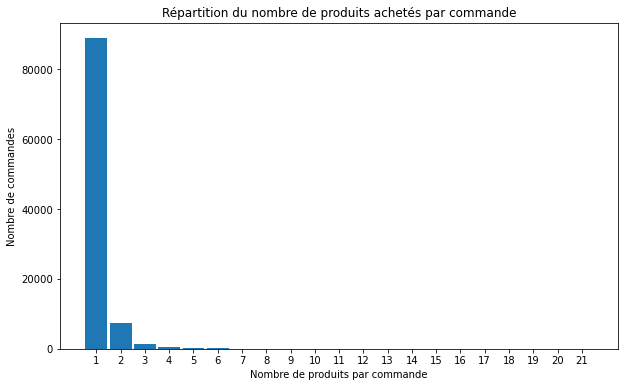

In [51]:

# Compter le nombre de produits achetés par commande
df_nb_produits = df_order_item.groupby("order_id")["order_item_id"].count()

# Définir la taille de la figure
plt.figure(figsize=(10, 6))

# Créer un histogramme du nombre de produits par commande
plt.hist(df_nb_produits, bins=range(1, df_nb_produits.max()+2), align='left', rwidth=0.9)
plt.xticks(range(1, df_nb_produits.max()+1))
plt.xlabel("Nombre de produits par commande")
plt.ylabel("Nombre de commandes")
plt.title("Répartition du nombre de produits achetés par commande")

# Afficher le graphique
plt.show()


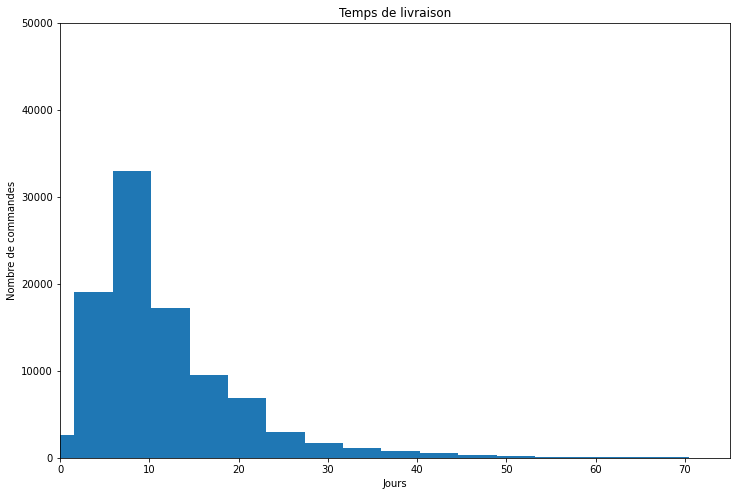

In [52]:
#Combien de temps faut-il en moyenne pour que les clients reçoivent leur commande ?

# Calculer le temps de livraison pour chaque commande
df_order_list['delivery_time'] = pd.to_datetime(df_order_list['order_delivered_customer_date']) - pd.to_datetime(df_order_list['order_approved_at'])
df_order_list['delivery_time'] = df_order_list['delivery_time'].dt.days

# Afficher l'histogramme du temps de livraison
plt.figure(figsize=(12, 8))

plt.hist(df_order_list['delivery_time'], bins=50)
plt.title("Temps de livraison")
plt.xlabel("Jours")
plt.ylabel("Nombre de commandes")
plt.xlim(0, 75) # Ajuster la limite de l'axe X entre 0 et 3000
plt.ylim(0, 50000) # Ajuster la limite de l'axe Y pour mieux visualiser les données
plt.show()


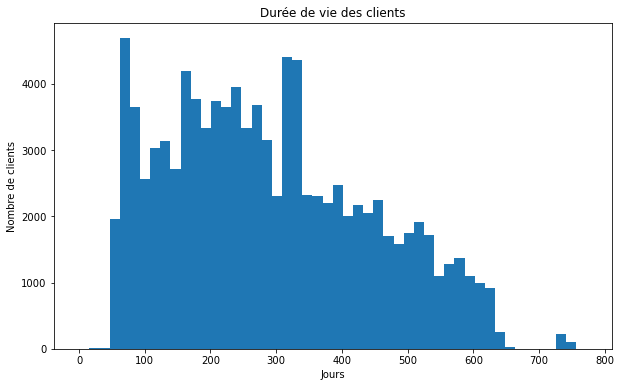

In [53]:
# Quelle est la durée de vie moyenne des clients sur le site ?


# Calculer la date la plus ancienne pour chaque client
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])
first_date = df_order_list.groupby('customer_id')['order_purchase_timestamp'].min().reset_index()

# Calculer la durée de vie pour chaque client
latest_date = df_order_list['order_purchase_timestamp'].max()
first_date['lifetime'] = (latest_date - first_date['order_purchase_timestamp']).dt.days

# Afficher l'histogramme de la durée de vie
plt.figure(figsize=(10, 6))

plt.hist(first_date['lifetime'], bins=50)
plt.title("Durée de vie des clients")
plt.xlabel("Jours")
plt.ylabel("Nombre de clients")
plt.show()


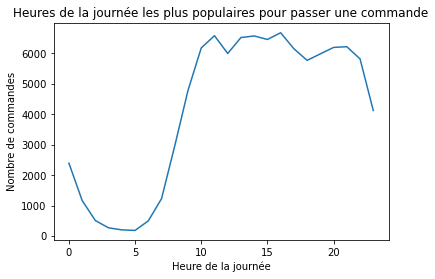

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données nécessaires
df_order_list = pd.read_csv("data/olist_orders_dataset.csv")

# Convertir la colonne order_purchase_timestamp en datetime
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])

# Extraire l'heure de la journée de la colonne order_purchase_timestamp
df_order_list['order_hour'] = df_order_list['order_purchase_timestamp'].dt.hour

# Compter le nombre de commandes par heure de la journée
hourly_orders = df_order_list.groupby('order_hour').size()

# Afficher le résultat
plt.plot(hourly_orders.index, hourly_orders.values)
plt.xlabel('Heure de la journée')
plt.ylabel('Nombre de commandes')
plt.title('Heures de la journée les plus populaires pour passer une commande')
plt.show()


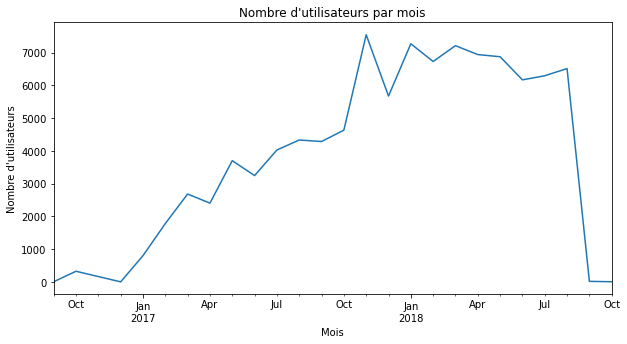

In [56]:
# Convertir la colonne "order_purchase_timestamp" en format datetime
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])

# Créer un graphique de ligne pour montrer l'évolution du nombre d'utilisateurs au fil du temps
users_by_month = df_order_list.groupby(df_order_list['order_purchase_timestamp'].dt.to_period('M'))['customer_id'].nunique()
users_by_month.plot(kind='line', figsize=(10,5))
plt.title("Nombre d'utilisateurs par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'utilisateurs")
plt.show()


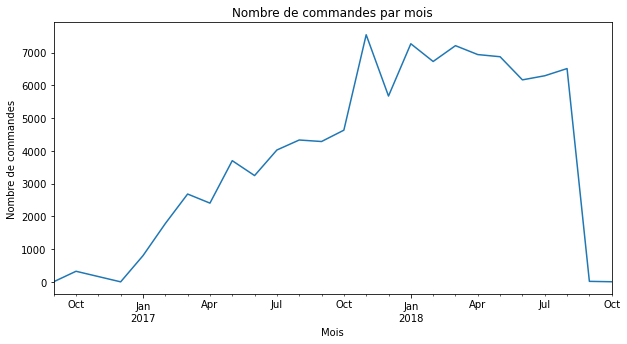

In [57]:
# Convertir la colonne order_purchase_timestamp en datetime
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])

# Créer une colonne pour le mois de la commande
df_order_list['order_month'] = df_order_list['order_purchase_timestamp'].dt.to_period('M')

# Compter le nombre de commandes par mois
monthly_orders = df_order_list['order_month'].value_counts().sort_index()

# Créer un graphique du nombre de commandes par mois
monthly_orders.plot(kind='line', figsize=(10, 5))
plt.title('Nombre de commandes par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')
plt.show()

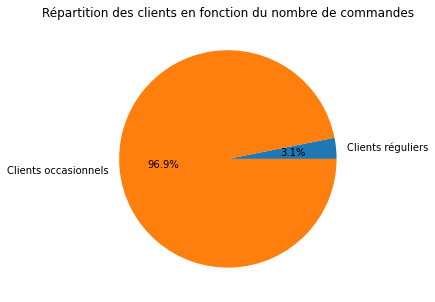

In [58]:
#Quel est la le nombre de client qui commande une nouvelle fois sur le site? 
# Fusionner les dataframes pour avoir la liste des commandes et des clients correspondants
df_order_customer = pd.merge(df_order_list, df_customer, on="customer_id")

# Compter le nombre de commandes par client
df_customer_orders = df_order_customer.groupby('customer_unique_id').count()['order_id']

# Compter le nombre de clients qui ont passé plusieurs commandes
df_repeat_customers = df_customer_orders[df_customer_orders > 1].count()

# Compter le nombre de clients qui n'ont passé qu'une seule commande
df_single_order_customers = df_customer_orders[df_customer_orders == 1].count()

# Créer un graphique en camembert pour visualiser les résultats
plt.figure(figsize=(10,5))
plt.pie([df_repeat_customers, df_single_order_customers], labels=['Clients réguliers', 'Clients occasionnels'], autopct='%1.1f%%')
plt.title('Répartition des clients en fonction du nombre de commandes')
plt.show()


In [3]:
# Convertir la colonne order_purchase_timestamp en datetime
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])

# Calculer la date la plus récente
latest_date = df_order_list['order_purchase_timestamp'].max()

# Calculer la récence, la fréquence et le montant pour chaque client
# regroupe les commandes par client.
rfm = df_order_list.groupby('customer_id').agg({
    #calcule la différence de temps entre la date la plus récente (latest_date) et la date d'achat la plus récente pour chaque client (x.max()).
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,
    'order_id': 'nunique',
}).reset_index()

# Renommer les colonnes
rfm.rename(columns={'order_purchase_timestamp': 'recency',
                     'order_id': 'frequency'}, inplace=True)

# Calculer le montant pour chaque client
monetary = df_order_item.groupby('order_id').agg({'price': 'sum'}).reset_index()
#Je merge les colonnes 'customer_id' et 'order_id' du dataframe 'df_order_list' au dataframe 'rfm' fusionner les données de deux dataframes sur'customer_id'
rfm = pd.merge(rfm, df_order_list[['customer_id', 'order_id']], on='customer_id')
rfm = pd.merge(rfm, monetary, on='order_id')
#Je drop la colonne order_id car j'ai fusionné les rfm et monetary sur la colonne order_id est elle est plus nécessaire maintenant
rfm.drop(['order_id'], axis=1, inplace=True)
rfm = rfm.groupby('customer_id').agg({'recency': 'min',
                                      'frequency': 'min',
                                      'price': 'sum'}).reset_index()
rfm.rename(columns={'price': 'monetary_value'}, inplace=True)

# Afficher le résultat
print(rfm.head())

                        customer_id  recency  frequency  monetary_value
0  00012a2ce6f8dcda20d059ce98491703      337          1           89.80
1  000161a058600d5901f007fab4c27140      458          1           54.90
2  0001fd6190edaaf884bcaf3d49edf079      596          1          179.99
3  0002414f95344307404f0ace7a26f1d5      427          1          149.90
4  000379cdec625522490c315e70c7a9fb      198          1           93.00


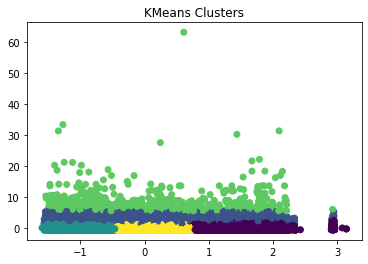

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardisation des données
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])

# Initialisation du modèle KMeans avec le nombre de clusters souhaité
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10).fit(rfm_std)

# Visualisation des clusters
plt.scatter(rfm_std['recency'], rfm_std['monetary_value'], c=kmeans.labels_)
plt.title("KMeans Clusters")
plt.show()



In [8]:
# Ajouter une colonne pour les labels de cluster
rfm['cluster'] = kmeans.labels_

# Définir les définitions pour chaque cluster
cluster_definitions = {
    0: "Clients peu récents avec des achats de faible valeur",
    1: "Clients récents et dépensiers",
    2: "Clients récents avec des achats de faible valeur",
    3: "Clients anciens mais très dépensiers",
    4: "Clients anciens avec des achats de faible valeur"
}

# Parcourir chaque cluster et afficher sa définition
for cluster_label, definition in cluster_definitions.items():
    print(f"Cluster {cluster_label}: {definition}")
    print("Recency mean:", round(rfm[rfm['cluster'] == cluster_label]['recency'].mean(), 2))
    print("Frequency mean:", round(rfm[rfm['cluster'] == cluster_label]['frequency'].mean(), 2))
    print("Monetary value mean:", round(rfm[rfm['cluster'] == cluster_label]['monetary_value'].mean(), 2))
    print()


Cluster 0: Clients peu récents avec des achats de faible valeur
Recency mean: 508.12
Frequency mean: 1.0
Monetary value mean: 105.24

Cluster 1: Clients récents et dépensiers
Recency mean: 279.76
Frequency mean: 1.0
Monetary value mean: 642.29

Cluster 2: Clients récents avec des achats de faible valeur
Recency mean: 135.97
Frequency mean: 1.0
Monetary value mean: 103.58

Cluster 3: Clients anciens mais très dépensiers
Recency mean: 294.09
Frequency mean: 1.0
Monetary value mean: 1898.12

Cluster 4: Clients anciens avec des achats de faible valeur
Recency mean: 304.29
Frequency mean: 1.0
Monetary value mean: 99.67



In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardisation des données
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])


# Je fais varier le nombre de clusters de 1 à 10
for n_clusters in range(1, 11):
    # Initialisation du modèle KMeans avec le nombre de clusters souhaité et entrainé le model avec la method fit
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(rfm_std)
   
   
    # Affichage de la somme des carrés des distances des échantillons au centre le plus proche
    print("Nombre de clusters : {} ; Inertie : {:.2f}".format(n_clusters, kmeans.inertia_))


Nombre de clusters : 1 ; Inertie : 197332.00
Nombre de clusters : 2 ; Inertie : 127909.82
Nombre de clusters : 3 ; Inertie : 76367.13
Nombre de clusters : 4 ; Inertie : 60561.79
Nombre de clusters : 5 ; Inertie : 45069.67
Nombre de clusters : 6 ; Inertie : 38911.09
Nombre de clusters : 7 ; Inertie : 35106.59
Nombre de clusters : 8 ; Inertie : 29453.87
Nombre de clusters : 9 ; Inertie : 26807.08
Nombre de clusters : 10 ; Inertie : 23837.64


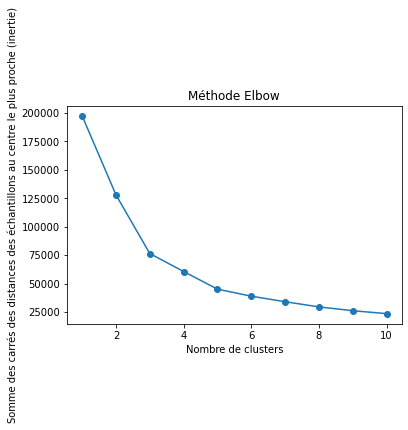

In [23]:
import matplotlib.pyplot as plt

# Initialisation de la liste pour stocker les valeurs d'inertie
inertias = []

for n_clusters in range(1, 11):
    # Initialisation du modèle KMeans avec le nombre de clusters souhaité
    kmeans = KMeans(n_clusters=5, random_state=1, n_init='auto').fit(rfm_std)
    # Entraînement du modèle sur les données standardisées
    # Ajout de l'inertie à la liste
    inertias.append(kmeans.inertia_)

# Tracer la courbe d'inertie en fonction du nombre de clusters
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
# Description de la documentation
plt.ylabel("Somme des distances au carré des échantillons à leur centre de grappe le plus proche(Inertie)")
plt.show()


In [36]:
from sklearn.metrics import silhouette_score
# note :Coefficient de silhouette ne peut pas être calculé avec un seul cluster
# Faire varier le nombre de clusters de 2 à 10
for n_clusters in range(2, 11):
    # Initialisation du modèle KMeans avec le nombre de clusters souhaité
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init=10).fit(rfm_std)
    # Entraînement du modèle sur les données standardisées
    # Calcul du coefficient de silhouette moyen pour les échantillons
    silhouette_avg = silhouette_score(rfm_std, kmeans.labels_)
    # Affichage du coefficient de silhouette moyen
    print("Nombre de clusters : {} ; Coefficient de silhouette moyen : {:.2f}".format(n_clusters, silhouette_avg))


Nombre de clusters : 2 ; Coefficient de silhouette moyen : 0.45
Nombre de clusters : 3 ; Coefficient de silhouette moyen : 0.49
Nombre de clusters : 4 ; Coefficient de silhouette moyen : 0.41
Nombre de clusters : 5 ; Coefficient de silhouette moyen : 0.43
Nombre de clusters : 6 ; Coefficient de silhouette moyen : 0.44
Nombre de clusters : 7 ; Coefficient de silhouette moyen : 0.38
Nombre de clusters : 8 ; Coefficient de silhouette moyen : 0.39
Nombre de clusters : 9 ; Coefficient de silhouette moyen : 0.40
Nombre de clusters : 10 ; Coefficient de silhouette moyen : 0.37


Variable : recency, F-value : 116268.51, p-value : 0.00
Variable : frequency, F-value : nan, p-value : nan
Variable : monetary_value, F-value : 61007.39, p-value : 0.00


C:\Users\Sylvain\anaconda3\lib\site-packages\scipy\stats\stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


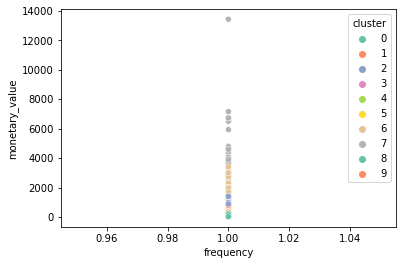

In [24]:
# Ajouter la colonne des clusters dans le dataframe
rfm['cluster'] = kmeans.labels_

# Afficher la moyenne des valeurs RFM pour chaque cluster
rfm.groupby('cluster').agg({'recency': 'mean', 'frequency': 'mean', 'monetary_value': 'mean'})

# Afficher le nombre de clients dans chaque cluster
rfm['cluster'].value_counts()

# Tracer un scatter plot pour visualiser les clusters
import seaborn as sns
sns.scatterplot(data=rfm, x='frequency', y='monetary_value', hue='cluster', palette='Set2')

# Faire une analyse de variance (ANOVA) pour voir s'il y a des différences significatives entre les clusters
from scipy.stats import f_oneway
for col in ['recency', 'frequency', 'monetary_value']:
    clusters = [rfm.loc[rfm['cluster'] == c, col] for c in range(n_clusters)]
    F, p = f_oneway(*clusters)
    print("Variable : {}, F-value : {:.2f}, p-value : {:.2f}".format(col, F, p))


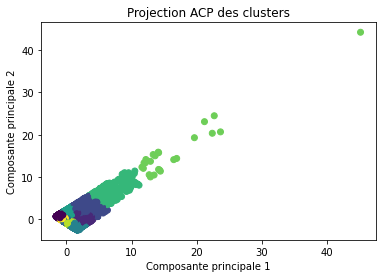

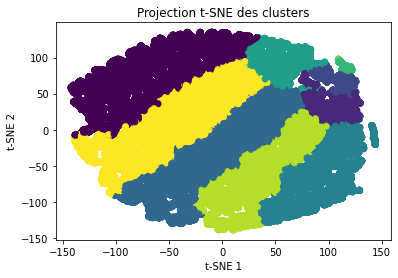

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimension avec ACP
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_std)

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1)
rfm_tsne = tsne.fit_transform(rfm_std)

# Création d'un scatter plot pour les clusters obtenus avec KMeans
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=kmeans.labels_)
plt.title('Projection ACP des clusters')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

plt.scatter(rfm_tsne[:,0], rfm_tsne[:,1], c=kmeans.labels_)
plt.title('Projection t-SNE des clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


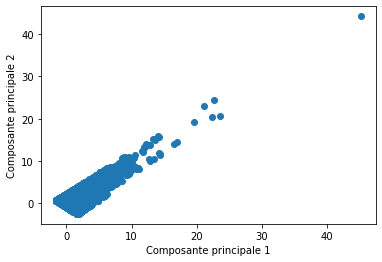

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardisation des données
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])

# Instanciation de l'objet PCA avec 2 composantes principales
pca = PCA(n_components=2)

# Calcul des composantes principales pour les données standardisées
principal_components = pca.fit_transform(rfm_std)

# Création d'un DataFrame avec les 2 premières composantes principales
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

# Visualisation en 2D des données projetées sur les 2 premières composantes principales
plt.scatter(principal_df['principal component 1'], principal_df['principal component 2'])
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


In [3]:
df_customer

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

In [6]:
df_order_item

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

In [25]:
df_merged = df_customer.merge(df_order_list, on='customer_id').merge(df_order_item, on='order_id').merge(df_order_payments, on='order_id').merge(df_order_review, on='order_id')


In [26]:
df_model = df_merged.dropna()


In [27]:
df_model

customer_id                customer_unique_id  \
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
16      a7c125a0a07b75146167b7f04a7f8e98  5c2991dbd08bbf3cf410713c4de5a0b5   
27      167bd30a409e3e4127df5a9408ebd394  9c0096673baf55453a50073f12d1a37f   
41      4c06b42fbf7b97ab10779cda5549cd1c  07d190f123147d9e89d4b922543d7948   
48      19cecb194f54e614b70d971306a9931b  d251c190ca75786e9ab937982d60d1d4   
...                                  ...                               ...   
117259  cb38d00c9e5573f32758d4d3dfa382ab  2dec450164b26f0f45ccbee550cd9091   
117261  d2a592f7064d3ef0f34bd7a8d95e4458  54038fdafde7c49533a306f961281d9c   
117262  d2a592f7064d3ef0f34bd7a8d95e4458  54038fdafde7c49533a306f961281d9c   
117318  be842c57a8c5a62e9585dd72f22b6338  ca186065de6e2d01cfc99763e6d62048   
117326  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   

        customer_zip_code_prefix   customer_city customer_state  \
4                          13056        campinas             SP   
16                         22750  rio de janeiro             RJ   
27                         74310         goiania             GO   
41                         65075        sao luis             MA   
48                         30320  belo horizonte             MG   
...                          ...             ...            ...   
117259                      5363       sao paulo             SP   
117261                     24350         niteroi             RJ   
117262                     24350         niteroi             RJ   
117318                     99150           marau             RS   
117326                     60115       fortaleza             CE   

                                order_id order_status  \
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
16      72bab69c50432c6f94d8b50a5f84b69a    delivered   
27      d10eafa208521dc30796e6a26099b6a6    delivered   
41      997fd4b37386d10b57d4ac8cdec011a6    delivered   
48      14282bc70be9bdda515182fb1ce62af4    delivered   
...                                  ...          ...   
117259  5a509a6537686bc8e701a4461631e965    delivered   
117261  4f88a7f264d48920c4f0762d160212ca    delivered   
117262  4f88a7f264d48920c4f0762d160212ca    delivered   
117318  75c3993b743335fa57b1645f056b59d2    delivered   
117326  fed4434add09a6f332ea398efd656a5c    delivered   

       order_purchase_timestamp    order_approved_at  \
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
16          2018-08-13 23:45:05  2018-08-13 23:55:13   
27          2018-07-14 10:53:11  2018-07-14 11:05:18   
41          2018-07-08 09:59:19  2018-07-08 10:30:15   
48          2018-04-18 14:18:09  2018-04-19 02:52:02   
...                         ...                  ...   
117259      2018-05-21 07:28:32  2018-05-22 08:16:33   
117261      2018-08-02 12:07:00  2018-08-02 13:05:18   
117262      2018-08-02 12:07:00  2018-08-02 13:05:18   
117318      2018-06-05 13:33:19  2018-06-06 02:55:19   
117326      2018-04-08 20:11:50  2018-04-08 20:30:03   

       order_delivered_carrier_date  ... payment_sequential payment_type  \
4               2018-07-30 15:16:00  ...                  1  credit_card   
16              2018-08-15 12:11:00  ...                  1  credit_card   
27              2018-07-17 17:32:00  ...                  1  credit_card   
41              2018-07-25 15:12:00  ...                  1  credit_card   
48              2018-04-20 00:47:44  ...                  1       boleto   
...                             ...  ...                ...          ...   
117259          2018-05-22 13:43:00  ...                  1       boleto   
117261          2018-08-14 11:39:00  ...                  1  credit_card   
117262          2018-08-14 11:39:00  ...                  1  credit_card   
117318          2018-06-07 12:39:00  ...                  1       boleto   
117326          2018-04-09 17:52:17  ...                  1  credit_card   

        payment_

In [5]:
# fusionner les dataframes
df_merged = pd.concat([df_customer, df_order_list, df_order_item, df_order_payments, df_order_review], axis=1)

# sélectionner les colonnes pertinentes
df_model = df_merged[['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_value', 'review_score']]



In [36]:
df_geoloc[['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']]


geolocation_zip_code_prefix geolocation_city geolocation_state
0                               1037        sao paulo                SP
1                               1046        sao paulo                SP
2                               1046        sao paulo                SP
3                               1041        sao paulo                SP
4                               1035        sao paulo                SP
...                              ...              ...               ...
1000158                        99950         tapejara                RS
1000159                        99900   getulio vargas                RS
1000160                        99950         tapejara                RS
1000161                        99980  david canabarro                RS
1000162                        99950         tapejara                RS

[1000163 rows x 3 columns]

In [28]:
# On combine les dataframes df_order_list, df_order_review et df_order_item en utilisant la colonne 'order_id'
df_merged = pd.merge(df_order_list, df_order_review, on='order_id')
df_merged = pd.merge(df_merged, df_order_item, on='order_id')

# On crée un dataframe avec les colonnes souhaitées
df_segmentation = df_merged[['customer_id', 'review_score', 'shipping_limit_date', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'price', 'freight_value']]

# On calcule la moyenne des scores de review pour chaque client
df_review_mean = df_segmentation.groupby('customer_id')['review_score'].mean().reset_index()

# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_review_mean, on='customer_id')

# Convertir les colonnes "order_delivered_customer_date" et "order_estimated_delivery_date" en type "datetime"
df_segmentation['order_delivered_customer_date'] = pd.to_datetime(df_segmentation['order_delivered_customer_date'])
df_segmentation['order_estimated_delivery_date'] = pd.to_datetime(df_segmentation['order_estimated_delivery_date'])

# On calcule la différence entre la date de livraison réelle et la date d'estimation de livraison pour chaque commande
df_segmentation['delivery_diff'] = (df_segmentation['order_delivered_customer_date'] - df_segmentation['order_estimated_delivery_date']).dt.days

# On calcule la moyenne de cette différence pour chaque client
df_delivery_mean = df_segmentation.groupby('customer_id')['delivery_diff'].mean().reset_index()

# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_delivery_mean, on='customer_id')

# On calcule le prix total payé pour chaque commande
df_order_payments['total_paid'] = df_order_payments['payment_value'] / df_order_payments['payment_installments']

# On fusionne les dataframes df_order_payments et df_order_list en utilisant la colonne 'order_id'
df_order_total = df_order_payments.merge(df_order_list[['order_id', 'customer_id']], on='order_id', how='left')

# On calcule le montant moyen payé pour chaque client
df_order_total = df_order_total.groupby('customer_id')['total_paid'].mean().reset_index()
# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_order_total, on='customer_id')



## Les deux autres parties

In [64]:
# Convertir les colonnes "order_delivered_customer_date" et "order_estimated_delivery_date" en type "datetime"
df_segmentation['order_delivered_customer_date'] = pd.to_datetime(df_segmentation['order_delivered_customer_date'])
df_segmentation['order_estimated_delivery_date'] = pd.to_datetime(df_segmentation['order_estimated_delivery_date'])

# On calcule la différence entre la date de livraison réelle et la date d'estimation de livraison pour chaque commande
df_segmentation['delivery_diff'] = (df_segmentation['order_delivered_customer_date'] - df_segmentation['order_estimated_delivery_date']).dt.days

# On calcule la moyenne de cette différence pour chaque client
df_delivery_mean = df_segmentation.groupby('customer_id')['delivery_diff'].mean().reset_index()

# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_delivery_mean, on='customer_id')


In [65]:

# On calcule le prix total payé pour chaque commande
df_order_payments['total_paid'] = df_order_payments['payment_value'] / df_order_payments['payment_installments']

# On fusionne les dataframes df_order_payments et df_order_list en utilisant la colonne 'order_id'
df_order_total = df_order_payments.merge(df_order_list[['order_id', 'customer_id']], on='order_id', how='left')

# On calcule le montant moyen payé pour chaque client
df_order_total = df_order_total.groupby('customer_id')['total_paid'].mean().reset_index()
# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_order_total, on='customer_id')





In [4]:
df_segmentation

customer_id  review_score_x  shipping_limit_date  \
0       9ef432eb6251297304e76186b10a928d               4  2017-10-06 11:07:15   
1       b0830fb4747a6c6d20dea0b8c802d7ef               4  2018-07-30 03:24:27   
2       41ce2a54c0b03bf3443c3d931a367089               5  2018-08-13 08:55:23   
3       f88197465ea7920adcdbec7375364d82               5  2017-11-23 19:45:59   
4       8ab97904e6daea8866dbdbc4fb7aad2c               5  2018-02-19 20:31:37   
...                                  ...             ...                  ...   
112364  1fca14ff2861355f6e5f14306ff977a7               4  2018-02-12 13:10:37   
112365  1aa71eb042121263aafbe80c1b562c9c               5  2017-09-05 15:04:16   
112366  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112367  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112368  edb027a75a1449115f6b43211ae02a24               5  2018-03-15 10:55:42   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-10-02 10:56:33           2017-10-10 21:25:13   
1           2018-07-24 20:41:37           2018-08-07 15:27:45   
2           2018-08-08 08:38:49           2018-08-17 18:06:29   
3           2017-11-18 19:28:06           2017-12-02 00:28:42   
4           2018-02-13 21:18:39           2018-02-16 18:17:02   
...                         ...                           ...   
112364      2018-02-06 12:58:58           2018-02-28 17:37:56   
112365      2017-08-27 14:46:43           2017-09-21 11:24:17   
112366      2018-01-08 21:28:27           2018-01-25 23:32:54   
112367      2018-01-08 21:28:27           2018-01-25 23:32:54   
112368      2018-03-08 20:57:30           2018-03-16 13:08:30   

       order_estimated_delivery_date   price  freight_value  review_score_y  \
0                         2017-10-18   29.99           8.72             4.0   
1                         2018-08-13  118.70          22.76             4.0   
2                         2018-09-04  159.90          19.22             5.0   
3                         2017-12-15   45.00          27.20             5.0   
4                         2018-02-26   19.90           8.72             5.0   
...                              ...     ...            ...             ...   
112364                    2018-03-02  174.90          20.10             4.0   
112365                    2017-09-27  205.99          65.02             5.0   
112366                    2018-02-15  179.99          40.59             2.0   
112367                    2018-02-15  179.99          40.59             2.0   
112368                    2018-04-03   68.50          18.36             5.0   

        delivery_diff_x  delivery_diff_y  total_paid  
0                  -8.0             -8.0   12.903333  
1                  -6.0             -6.0  141.460000  
2                 -18.0            -18.0   59.706667  
3                 -13.0            -13.0   72.200000  
4                 -10.0            -10.0   28.620000  
...                 ...              ...         ...  
112364             -2.0             -2.0   65.000000  
112365             -6.0             -6.0   54.202000  
112366            -21.0            -21.0  110.290000  
112367            -21.0            -21.0  110.290000  
112368            -18.0            -18.0   86.860000  

[112369 rows x 12 columns]

In [5]:
# On fusionne df_order_list et df_order_item sur la colonne 'order_id'
df_order_product = pd.merge(df_order_list, df_order_item, on='order_id')

# On fusionne df_order_product et df_product_list sur la colonne 'product_id'
df_order_product_category = pd.merge(df_order_product, df_product_list[['product_id', 'product_category_name']], on='product_id')

# On regroupe par 'customer_id' et on crée une liste de toutes les catégories de produits commandées par chaque client
df_product_categories = df_order_product_category.groupby('customer_id')['product_category_name'].apply(list).reset_index()

# On ajoute cette information dans le dataframe de segmentation
df_segmentation = pd.merge(df_segmentation, df_product_categories, on='customer_id')



In [6]:
df_segmentation

customer_id  review_score_x  shipping_limit_date  \
0       9ef432eb6251297304e76186b10a928d               4  2017-10-06 11:07:15   
1       b0830fb4747a6c6d20dea0b8c802d7ef               4  2018-07-30 03:24:27   
2       41ce2a54c0b03bf3443c3d931a367089               5  2018-08-13 08:55:23   
3       f88197465ea7920adcdbec7375364d82               5  2017-11-23 19:45:59   
4       8ab97904e6daea8866dbdbc4fb7aad2c               5  2018-02-19 20:31:37   
...                                  ...             ...                  ...   
112364  1fca14ff2861355f6e5f14306ff977a7               4  2018-02-12 13:10:37   
112365  1aa71eb042121263aafbe80c1b562c9c               5  2017-09-05 15:04:16   
112366  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112367  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112368  edb027a75a1449115f6b43211ae02a24               5  2018-03-15 10:55:42   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-10-02 10:56:33           2017-10-10 21:25:13   
1           2018-07-24 20:41:37           2018-08-07 15:27:45   
2           2018-08-08 08:38:49           2018-08-17 18:06:29   
3           2017-11-18 19:28:06           2017-12-02 00:28:42   
4           2018-02-13 21:18:39           2018-02-16 18:17:02   
...                         ...                           ...   
112364      2018-02-06 12:58:58           2018-02-28 17:37:56   
112365      2017-08-27 14:46:43           2017-09-21 11:24:17   
112366      2018-01-08 21:28:27           2018-01-25 23:32:54   
112367      2018-01-08 21:28:27           2018-01-25 23:32:54   
112368      2018-03-08 20:57:30           2018-03-16 13:08:30   

       order_estimated_delivery_date   price  freight_value  review_score_y  \
0                         2017-10-18   29.99           8.72             4.0   
1                         2018-08-13  118.70          22.76             4.0   
2                         2018-09-04  159.90          19.22             5.0   
3                         2017-12-15   45.00          27.20             5.0   
4                         2018-02-26   19.90           8.72             5.0   
...                              ...     ...            ...             ...   
112364                    2018-03-02  174.90          20.10             4.0   
112365                    2017-09-27  205.99          65.02             5.0   
112366                    2018-02-15  179.99          40.59             2.0   
112367                    2018-02-15  179.99          40.59             2.0   
112368                    2018-04-03   68.50          18.36             5.0   

        delivery_diff_x  delivery_diff_y  total_paid  \
0                  -8.0             -8.0   12.903333   
1                  -6.0             -6.0  141.460000   
2                 -18.0            -18.0   59.706667   
3                 -13.0            -13.0   72.200000   
4                 -10.0            -10.0   28.620000   
...                 ...              ...         ...   
112364             -2.0             -2.0   65.000000   
112365             -6.0             -6.0   54.202000   
112366            -21.0            -21.0  110.290000   
112367            -21.0            -21.0  110.290000   
112368            -18.0            -18.0   86.860000   

                                   product_category_name  
0                                [utilidades_domesticas]  
1                                           [perfumaria]  
2                                           [automotivo]  
3                                             [pet_shop]  
4                                            [papelaria]  
...                                                  ...  
112364                                           [bebes]  
112365                              [eletrodomesticos_2]  
112366  [informatica_acessorios, informatica_acessorios]  
112367  [informatica_acessorios, informatica_acessorios]  
1123

In [30]:
# Créer une table croisée des produits commandés par catégorie
product_category_table = pd.pivot_table(df_order_item, values='product_id', index='order_id', columns='product_category_name', aggfunc='count', fill_value=0)

# Identifier la catégorie la plus fréquemment commandée pour chaque commande
df_order_item['most_common_category'] = product_category_table.idxmax(axis=1)

# Fusionner le résultat avec le DataFrame original
df_segmentation = pd.merge(df_segmentation, df_order_item[['order_id', 'most_common_category']], on='order_id', how='left')




KeyError: 'product_category_name'

In [25]:
df_segmentation

customer_id  review_score_x  shipping_limit_date  \
0       9ef432eb6251297304e76186b10a928d               4  2017-10-06 11:07:15   
1       b0830fb4747a6c6d20dea0b8c802d7ef               4  2018-07-30 03:24:27   
2       41ce2a54c0b03bf3443c3d931a367089               5  2018-08-13 08:55:23   
3       f88197465ea7920adcdbec7375364d82               5  2017-11-23 19:45:59   
4       8ab97904e6daea8866dbdbc4fb7aad2c               5  2018-02-19 20:31:37   
...                                  ...             ...                  ...   
112364  1fca14ff2861355f6e5f14306ff977a7               4  2018-02-12 13:10:37   
112365  1aa71eb042121263aafbe80c1b562c9c               5  2017-09-05 15:04:16   
112366  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112367  b331b74b18dc79bcdf6532d51e1637c1               2  2018-01-12 21:36:21   
112368  edb027a75a1449115f6b43211ae02a24               5  2018-03-15 10:55:42   

       order_purchase_timestamp order_delivered_customer_date  \
0           2017-10-02 10:56:33           2017-10-10 21:25:13   
1           2018-07-24 20:41:37           2018-08-07 15:27:45   
2           2018-08-08 08:38:49           2018-08-17 18:06:29   
3           2017-11-18 19:28:06           2017-12-02 00:28:42   
4           2018-02-13 21:18:39           2018-02-16 18:17:02   
...                         ...                           ...   
112364      2018-02-06 12:58:58           2018-02-28 17:37:56   
112365      2017-08-27 14:46:43           2017-09-21 11:24:17   
112366      2018-01-08 21:28:27           2018-01-25 23:32:54   
112367      2018-01-08 21:28:27           2018-01-25 23:32:54   
112368      2018-03-08 20:57:30           2018-03-16 13:08:30   

       order_estimated_delivery_date   price  freight_value  review_score_y  \
0                         2017-10-18   29.99           8.72             4.0   
1                         2018-08-13  118.70          22.76             4.0   
2                         2018-09-04  159.90          19.22             5.0   
3                         2017-12-15   45.00          27.20             5.0   
4                         2018-02-26   19.90           8.72             5.0   
...                              ...     ...            ...             ...   
112364                    2018-03-02  174.90          20.10             4.0   
112365                    2017-09-27  205.99          65.02             5.0   
112366                    2018-02-15  179.99          40.59             2.0   
112367                    2018-02-15  179.99          40.59             2.0   
112368                    2018-04-03   68.50          18.36             5.0   

        delivery_diff_x  delivery_diff_y  total_paid  cama_mesa_banho  \
0                  -8.0             -8.0   12.903333                0   
1                  -6.0             -6.0  141.460000                0   
2                 -18.0            -18.0   59.706667                0   
3                 -13.0            -13.0   72.200000                0   
4                 -10.0            -10.0   28.620000                0   
...                 ...              ...         ...              ...   
112364             -2.0             -2.0   65.000000                0   
112365             -6.0             -6.0   54.202000                0   
112366            -21.0            -21.0  110.290000                0   
112367            -21.0            -21.0  110.290000                0   
112368            -18.0            -18.0   86.860000                0   

        beleza_saude  esporte_lazer  informatica_acessorios  moveis_decoracao  
0                  0              0                       0                 0  
1                  0              0                       0                 0  
2                  0              0                       0                 0  
3                  0              0                       0                 0  
4                  0              0              

<AxesSubplot:>

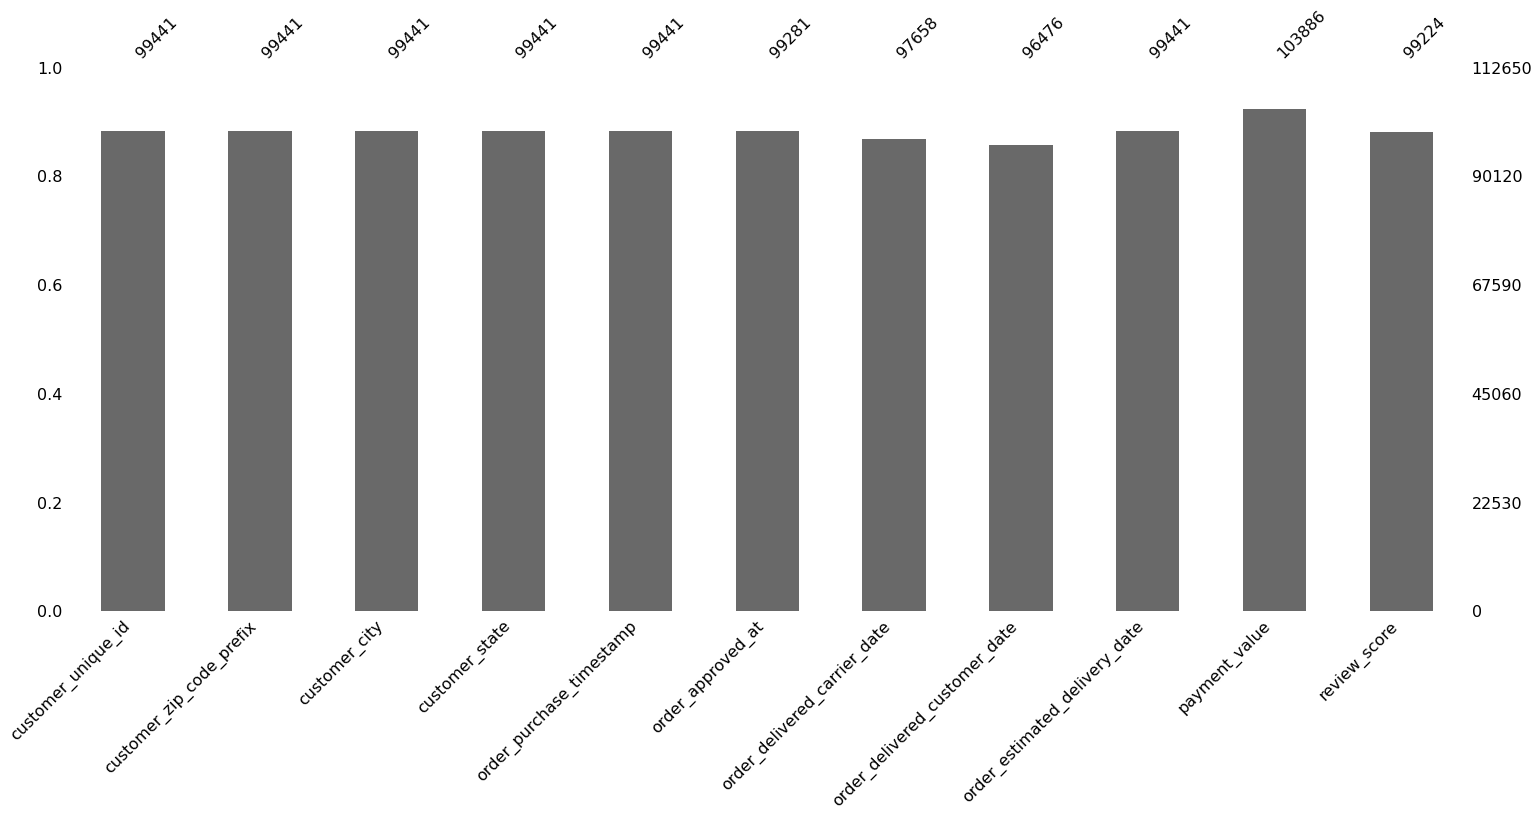

In [5]:
msno.bar(df_model)

In [8]:
df_model

customer_unique_id  customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0                   14409.0   
1      290c77bc529b7ac935b93aa66c333dc3                    9790.0   
2      060e732b5b29e8181a18229c7b0b2b5e                    1151.0   
3      259dac757896d24d7702b9acbbff3f3c                    8775.0   
4      345ecd01c38d18a9036ed96c73b8d066                   13056.0   
...                                 ...                       ...   
99219  5570e312bd641ceba38f678cf62ca055                   12710.0   
99220  8c8268a2915979efa64b481617356861                    4641.0   
99221  9e663beb35e5b7bbe980b5768dbf0898                   19400.0   
99222  763d19266fad3c4720da38d5764b5317                   17211.0   
99223  2444e57c718501efe5dcdcc6576f57c4                   17700.0   

               customer_city customer_state order_purchase_timestamp  \
0                     franca             SP      2017-10-02 10:56:33   
1      sao bernardo do campo             SP      2018-07-24 20:41:37   
2                  sao paulo             SP      2018-08-08 08:38:49   
3            mogi das cruzes             SP      2017-11-18 19:28:06   
4                   campinas             SP      2018-02-13 21:18:39   
...                      ...            ...                      ...   
99219               cruzeiro             SP      2018-03-03 08:45:50   
99220              sao paulo             SP      2017-12-10 01:10:15   
99221   presidente venceslau             SP      2018-07-20 20:50:26   
99222                    jau             SP      2017-09-02 20:38:29   
99223           osvaldo cruz             SP      2018-06-09 21:51:46   

         order_approved_at order_delivered_carrier_date  \
0      2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 22:20:29          2018-02-14 19:46:34   
...                    ...                          ...   
99219  2018-03-03 09:08:35          2018-03-05 19:19:50   
99220  2017-12-10 01:43:06          2017-12-11 17:45:10   
99221  2018-07-20 21:03:48          2018-07-23 09:13:00   
99222  2017-09-05 04:24:12          2017-09-14 23:13:41   
99223  2018-06-09 22:19:06          2018-06-11 11:20:00   

      order_delivered_customer_date order_estimated_delivery_date  \
0               2017-10-10 21:25:13           2017-10-18 00:00:00   
1               2018-08-07 15:27:45           2018-08-13 00:00:00   
2               2018-08-17 18:06:29           2018-09-04 00:00:00   
3               2017-12-02 00:28:42           2017-12-15 00:00:00   
4               2018-02-16 18:17:02           2018-02-26 00:00:00   
...                             ...                           ...   
99219           2018-03-18 15:55:22           2018-04-03 00:00:00   
99220           2017-12-15 17:29:30           2018-01-05 00:00:00   
99221           2018-07-25 00:03:31           2018-08-01 00:00:00   
99222           2017-09-15 14:59:50           2017-09-19 00:00:00   
99223           2018-06-14 00:21:19           2018-06-26 00:00:00   

       payment_value  review_score  
0              99.33           4.0  
1              24.39           5.0  
2              65.71           5.0  
3             107.78           5.0  
4             128.45           5.0  
...              ...           ...  
99219         297.58           5.0  
99220         648.77           5.0  
99221          51.25           5.0  
99222          48.75           4.0  
99223         284.63           1.0  

[96251 rows x 11 columns]

In [6]:
df_model = df_model.dropna()

<AxesSubplot:>

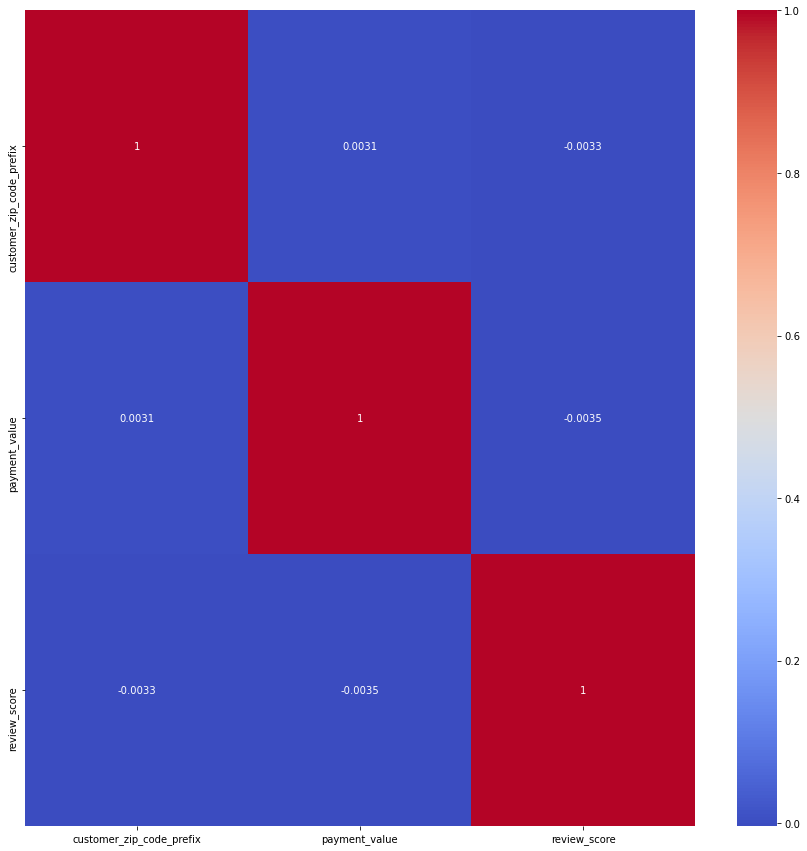

In [10]:
import seaborn as sns

# Créer une heatmap des corrélations
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_model.corr(), cmap='coolwarm', annot=True)

In [8]:
# Sélection des variables catégorielles
cat_vars = df_model.select_dtypes(include=['object']).columns

# Affichage des variables catégorielles
print("Variables catégorielles : ", cat_vars)

Variables catégorielles :  Index(['customer_unique_id', 'customer_city', 'customer_state',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')


In [14]:
# Sélectionner les colonnes numériques
numeric_cols = df_model.select_dtypes(include=[np.number]).columns

# Afficher les noms des colonnes sélectionnées
print("Variables continue : " ,numeric_cols)

Variables continue :  Index(['customer_zip_code_prefix', 'payment_value', 'review_score'], dtype='object')


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Instancier l'objet OneHotEncoder avec min_frequency
encoder = OneHotEncoder(handle_unknown='error', sparse_output=False, min_frequency=0.05)

# Sélectionner les colonnes à encoder
cols_to_encode = ['customer_unique_id', 'customer_city', 'customer_state',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date']

# Encoder les colonnes sélectionnées
onehot_encoded = encoder.fit_transform(df_model[cols_to_encode])

# Générer les noms de colonnes
columns = encoder.get_feature_names_out(cols_to_encode)

# Créer un DataFrame à partir des résultats de l'encodage
df_encoding = pd.DataFrame(onehot_encoded, columns=columns)

# Concaténer le DataFrame d'encodage avec le DataFrame original
df_model = pd.concat([df_model, df_encoding], axis=1)





In [16]:
df_model.loc[df_model['customer_state_SP']== 0]['customer_state_infrequent_sklearn'].count()

55841

In [12]:
df_model

customer_unique_id  customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0                   14409.0   
1      290c77bc529b7ac935b93aa66c333dc3                    9790.0   
2      060e732b5b29e8181a18229c7b0b2b5e                    1151.0   
3      259dac757896d24d7702b9acbbff3f3c                    8775.0   
4      345ecd01c38d18a9036ed96c73b8d066                   13056.0   
...                                 ...                       ...   
99219  5570e312bd641ceba38f678cf62ca055                   12710.0   
99220  8c8268a2915979efa64b481617356861                    4641.0   
99221  9e663beb35e5b7bbe980b5768dbf0898                   19400.0   
99222  763d19266fad3c4720da38d5764b5317                   17211.0   
99223  2444e57c718501efe5dcdcc6576f57c4                   17700.0   

               customer_city customer_state order_purchase_timestamp  \
0                     franca             SP      2017-10-02 10:56:33   
1      sao bernardo do campo             SP      2018-07-24 20:41:37   
2                  sao paulo             SP      2018-08-08 08:38:49   
3            mogi das cruzes             SP      2017-11-18 19:28:06   
4                   campinas             SP      2018-02-13 21:18:39   
...                      ...            ...                      ...   
99219               cruzeiro             SP      2018-03-03 08:45:50   
99220              sao paulo             SP      2017-12-10 01:10:15   
99221   presidente venceslau             SP      2018-07-20 20:50:26   
99222                    jau             SP      2017-09-02 20:38:29   
99223           osvaldo cruz             SP      2018-06-09 21:51:46   

         order_approved_at order_delivered_carrier_date  \
0      2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 22:20:29          2018-02-14 19:46:34   
...                    ...                          ...   
99219  2018-03-03 09:08:35          2018-03-05 19:19:50   
99220  2017-12-10 01:43:06          2017-12-11 17:45:10   
99221  2018-07-20 21:03:48          2018-07-23 09:13:00   
99222  2017-09-05 04:24:12          2017-09-14 23:13:41   
99223  2018-06-09 22:19:06          2018-06-11 11:20:00   

      order_delivered_customer_date order_estimated_delivery_date  \
0               2017-10-10 21:25:13           2017-10-18 00:00:00   
1               2018-08-07 15:27:45           2018-08-13 00:00:00   
2               2018-08-17 18:06:29           2018-09-04 00:00:00   
3               2017-12-02 00:28:42           2017-12-15 00:00:00   
4               2018-02-16 18:17:02           2018-02-26 00:00:00   
...                             ...                           ...   
99219           2018-03-18 15:55:22           2018-04-03 00:00:00   
99220           2017-12-15 17:29:30           2018-01-05 00:00:00   
99221           2018-07-25 00:03:31           2018-08-01 00:00:00   
99222           2017-09-15 14:59:50           2017-09-19 00:00:00   
99223           2018-06-14 00:21:19           2018-06-26 00:00:00   

       payment_value  ...  customer_state_PR  customer_state_RJ  \
0              99.33  ...                0.0                0.0   
1              24.39  ...                0.0                0.0   
2              65.71  ...                0.0                0.0   
3             107.78  ...                0.0                0.0   
4             128.45  ...                0.0                0.0   
...              ...  ...                ...                ...   
99219         297.58  ...                0.0                0.0   
99220         648.77  ...                0.0                0.0   
99221          51.25  ...                0.0                0.0   
99222          48.75  ...                0.0                0.0   
99223         284.63  ...                0.0        

<AxesSubplot:>

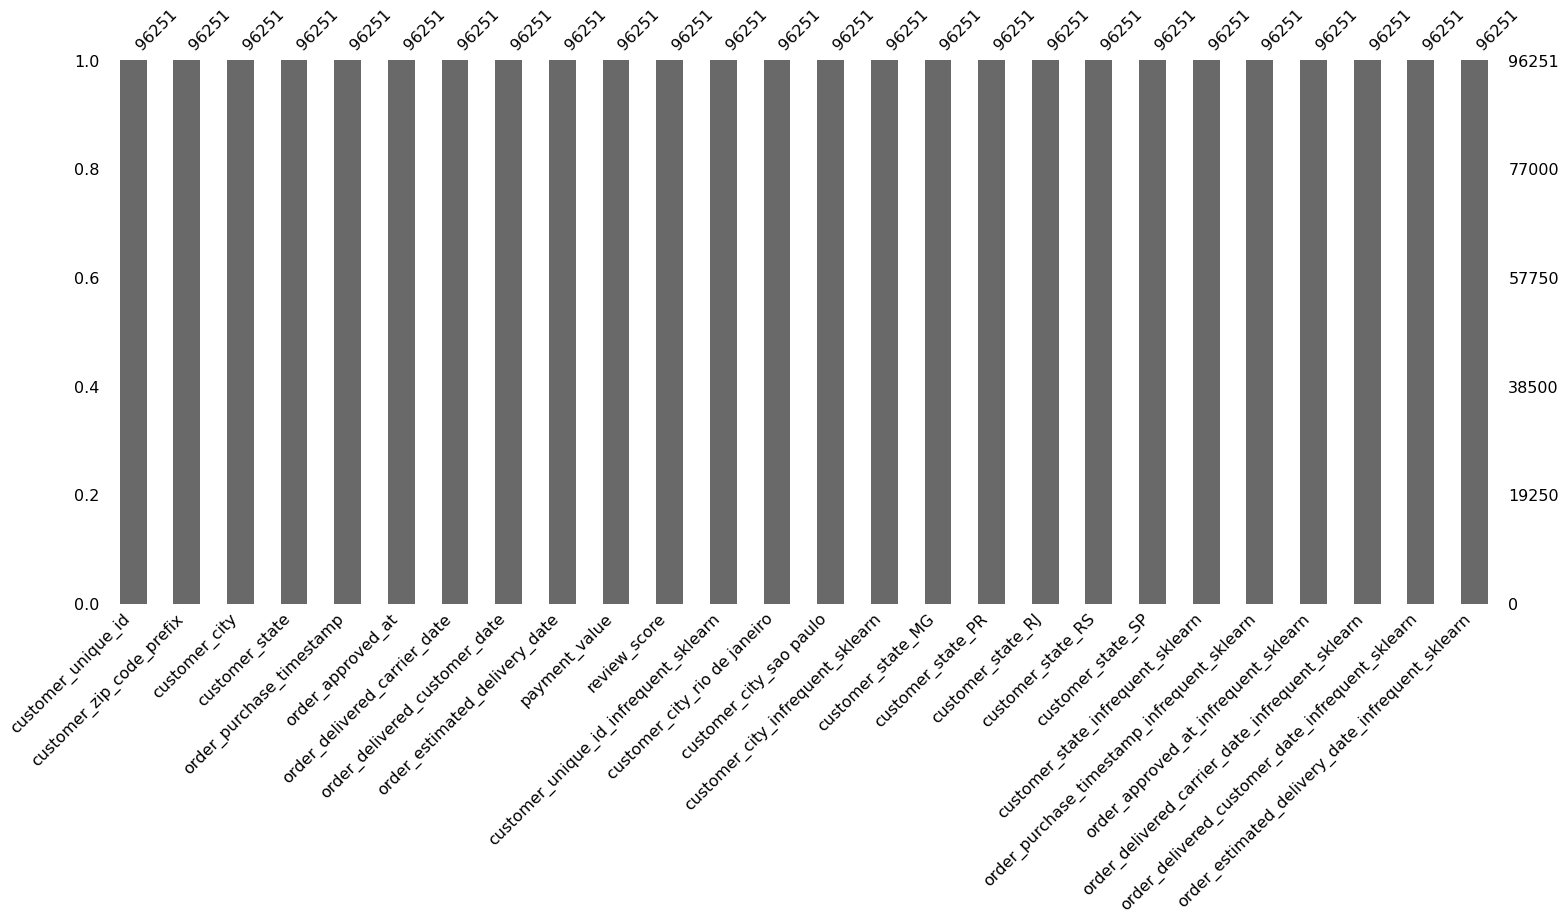

In [18]:
msno.bar(df_model)

In [8]:
df_models = df_model.drop(['customer_unique_id', 'customer_city', 'customer_state',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'], axis=1)


In [8]:
df_models

customer_zip_code_prefix  payment_value  review_score  \
0                       14409.0          99.33           4.0   
1                        9790.0          24.39           5.0   
2                        1151.0          65.71           5.0   
3                        8775.0         107.78           5.0   
4                       13056.0         128.45           5.0   
...                         ...            ...           ...   
99219                   12710.0         297.58           5.0   
99220                    4641.0         648.77           5.0   
99221                   19400.0          51.25           5.0   
99222                   17211.0          48.75           4.0   
99223                   17700.0         284.63           1.0   

       customer_unique_id_infrequent_sklearn  customer_city_rio de janeiro  \
0                                        1.0                           0.0   
1                                        1.0                           0.0   
2                                        1.0                           0.0   
3                                        1.0                           0.0   
4                                        1.0                           0.0   
...                                      ...                           ...   
99219                                    1.0                           0.0   
99220                                    1.0                           0.0   
99221                                    1.0                           0.0   
99222                                    1.0                           0.0   
99223                                    1.0                           0.0   

       customer_city_sao paulo  customer_city_infrequent_sklearn  \
0                          0.0                               1.0   
1                          0.0                               1.0   
2                          1.0                               0.0   
3                          0.0                               1.0   
4                          0.0                               1.0   
...                        ...                               ...   
99219                      0.0                               1.0   
99220                      1.0                               0.0   
99221                      0.0                               1.0   
99222                      0.0                               1.0   
99223                      0.0                               1.0   

       customer_state_MG  customer_state_PR  customer_state_RJ  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99219                0.0                0.0                0.0   
99220                0.0                0.0                0.0   
99221                0.0                0.0                0.0   
99222                0.0                0.0                0.0   
99223                0.0                0.0                0.0   

       customer_state_RS  customer_state_SP  \
0                    0.0                1.0   
1                    0.0                1.0   
2                    0.0                1.0   
3                    0.0                1.0   
4                    0.0                1.0   
...                  ...                ...   
99219                0.0                1.0   
99220                0.0                1.0   
99221                0.0                1.0   
99222                0.0                1.0   
99223                0.0                1.0   

       customer_state_infrequent_sklearn  \
0                                    0.0   
1                                    0

In [9]:
df_models.isna()

customer_zip_code_prefix  payment_value  review_score  \
0                         False          False         False   
1                         False          False         False   
2                         False          False         False   
3                         False          False         False   
4                         False          False         False   
...                         ...            ...           ...   
99219                     False          False         False   
99220                     False          False         False   
99221                     False          False         False   
99222                     False          False         False   
99223                     False          False         False   

       customer_unique_id_infrequent_sklearn  customer_city_rio de janeiro  \
0                                      False                         False   
1                                      False                         False   
2                                      False                         False   
3                                      False                         False   
4                                      False                         False   
...                                      ...                           ...   
99219                                  False                         False   
99220                                  False                         False   
99221                                  False                         False   
99222                                  False                         False   
99223                                  False                         False   

       customer_city_sao paulo  customer_city_infrequent_sklearn  \
0                        False                             False   
1                        False                             False   
2                        False                             False   
3                        False                             False   
4                        False                             False   
...                        ...                               ...   
99219                    False                             False   
99220                    False                             False   
99221                    False                             False   
99222                    False                             False   
99223                    False                             False   

       customer_state_MG  customer_state_PR  customer_state_RJ  \
0                  False              False              False   
1                  False              False              False   
2                  False              False              False   
3                  False              False              False   
4                  False              False              False   
...                  ...                ...                ...   
99219              False              False              False   
99220              False              False              False   
99221              False              False              False   
99222              False              False              False   
99223              False              False              False   

       customer_state_RS  customer_state_SP  \
0                  False              False   
1                  False              False   
2                  False              False   
3                  False              False   
4                  False              False   
...                  ...                ...   
99219              False              False   
99220              False              False   
99221              False              False   
99222              False              False   
99223              False              False   

       customer_state_infrequent_sklearn  \
0                                  False   
1                                  Fal

In [ ]:
# fusionner les dataframes
#df_merged = pd.concat([df_customer, df_order_list, df_order_item, df_order_payments, df_product_list, df_seller_list, df_order_review], axis=1)

# sélectionner les colonnes pertinentes
#df_model = df_merged[['customer_unique_id', 'customer_city', 'customer_state', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_status', 'review_score', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_id', 'seller_city', 'seller_state']]


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(transform_output="pandas")
scaler = StandardScaler()
df_model_imputed = scaler.fit_transform(df_models[['customer_zip_code_prefix','payment_value','review_score']])
df_models[['customer_zip_code_prefix', 'payment_value', 'review_score']] = df_model_imputed

In [15]:
df_models

customer_zip_code_prefix  payment_value  review_score  \
0                     -0.695215      -0.253545     -0.065190   
1                     -0.850245      -0.600010      0.677458   
2                     -1.140200      -0.408978      0.677458   
3                     -0.884312      -0.214479      0.677458   
4                     -0.740626      -0.118917      0.677458   
...                         ...            ...           ...   
99219                 -0.752239       0.663010      0.677458   
99220                 -1.023063       2.286642      0.677458   
99221                 -0.527699      -0.475830      0.677458   
99222                 -0.601170      -0.487388     -0.065190   
99223                 -0.584757       0.603139     -2.293136   

       customer_unique_id_infrequent_sklearn  customer_city_rio de janeiro  \
0                                        1.0                           0.0   
1                                        1.0                           0.0   
2                                        1.0                           0.0   
3                                        1.0                           0.0   
4                                        1.0                           0.0   
...                                      ...                           ...   
99219                                    1.0                           0.0   
99220                                    1.0                           0.0   
99221                                    1.0                           0.0   
99222                                    1.0                           0.0   
99223                                    1.0                           0.0   

       customer_city_sao paulo  customer_city_infrequent_sklearn  \
0                          0.0                               1.0   
1                          0.0                               1.0   
2                          1.0                               0.0   
3                          0.0                               1.0   
4                          0.0                               1.0   
...                        ...                               ...   
99219                      0.0                               1.0   
99220                      1.0                               0.0   
99221                      0.0                               1.0   
99222                      0.0                               1.0   
99223                      0.0                               1.0   

       customer_state_MG  customer_state_PR  customer_state_RJ  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99219                0.0                0.0                0.0   
99220                0.0                0.0                0.0   
99221                0.0                0.0                0.0   
99222                0.0                0.0                0.0   
99223                0.0                0.0                0.0   

       customer_state_RS  customer_state_SP  \
0                    0.0                1.0   
1                    0.0                1.0   
2                    0.0                1.0   
3                    0.0                1.0   
4                    0.0                1.0   
...                  ...                ...   
99219                0.0                1.0   
99220                0.0                1.0   
99221                0.0                1.0   
99222                0.0                1.0   
99223                0.0                1.0   

       customer_state_infrequent_sklearn  \
0                                    0.0   
1                                    0

In [59]:
#from sklearn.impute import KNNImputer

#imputer = KNNImputer(n_neighbors=1)
#df_models = imputer.fit_transform(df_models[['customer_zip_code_prefix','payment_value','review_score']])

<AxesSubplot:>

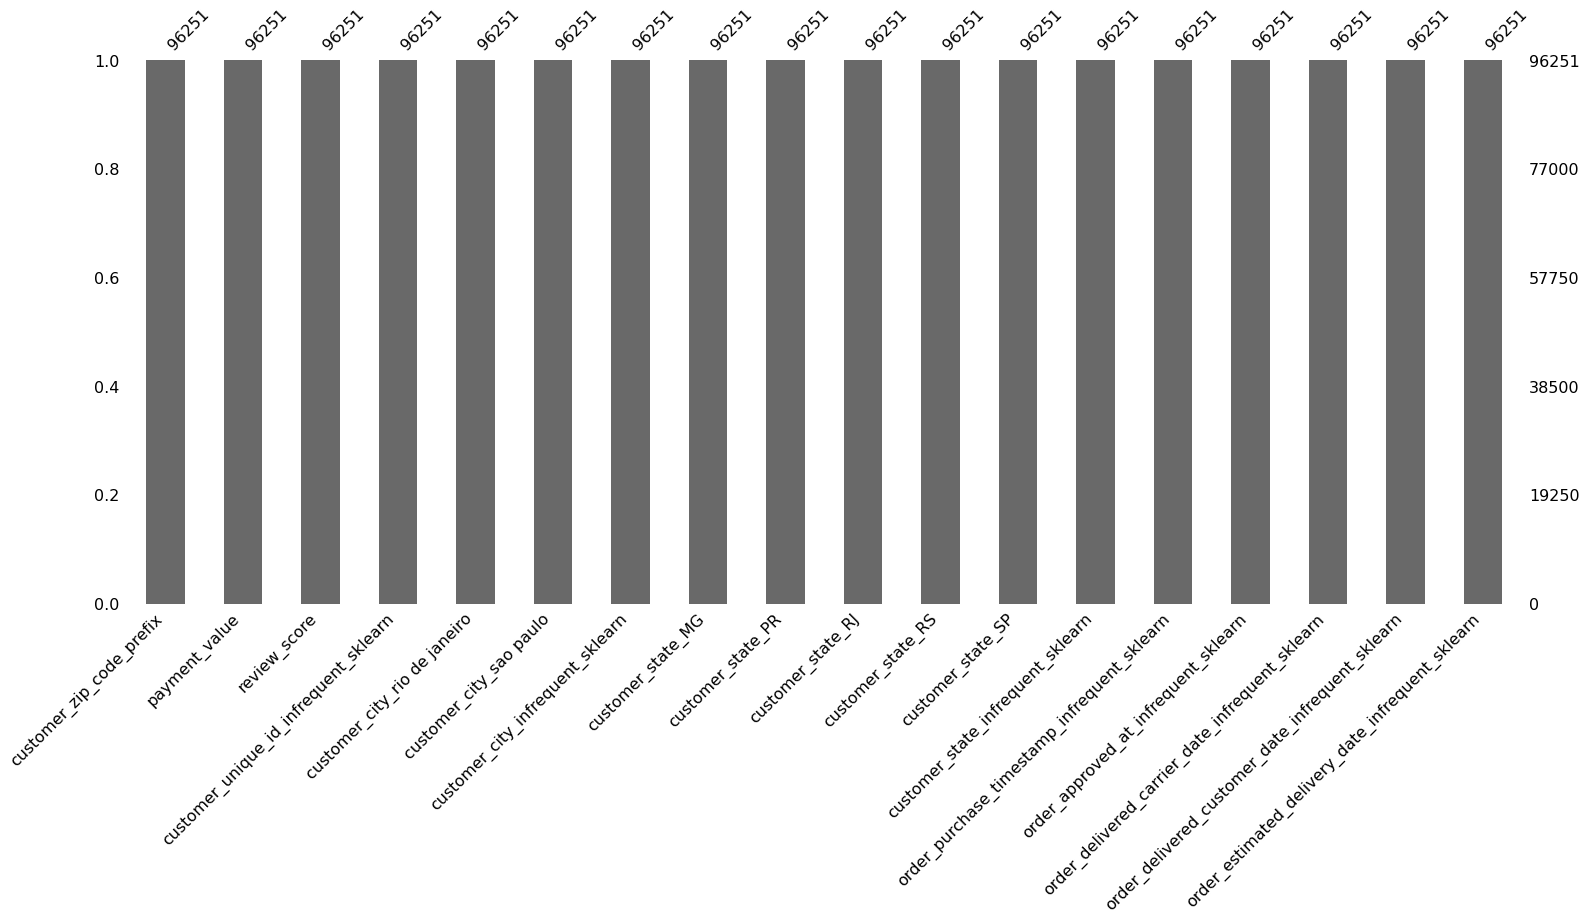

In [92]:
msno.bar(df_models)

In [46]:
# Sélection des variables catégorielles
cat_vars = df_model.select_dtypes(include=['object']).columns

# Affichage des variables catégorielles
print("Variables catégorielles : ", cat_vars)

Variables catégorielles :  Index(['customer_unique_id', 'customer_city', 'customer_state',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_status', 'payment_type'],
      dtype='object')


In [50]:
# Sélection des variables catégorielles
cat_vars = df_model.select_dtypes(include=['object']).columns

# Affichage des variables catégorielles
print("Variables catégorielles : ", cat_vars)

Variables catégorielles :  Index([], dtype='object')


In [21]:
df_models

customer_zip_code_prefix  payment_value  review_score  \
0                     -0.695215      -0.253545     -0.065190   
1                     -0.850245      -0.600010      0.677458   
2                     -1.140200      -0.408978      0.677458   
3                     -0.884312      -0.214479      0.677458   
4                     -0.740626      -0.118917      0.677458   
...                         ...            ...           ...   
99219                 -0.752239       0.663010      0.677458   
99220                 -1.023063       2.286642      0.677458   
99221                 -0.527699      -0.475830      0.677458   
99222                 -0.601170      -0.487388     -0.065190   
99223                 -0.584757       0.603139     -2.293136   

       customer_unique_id_infrequent_sklearn  customer_city_rio de janeiro  \
0                                        1.0                           0.0   
1                                        1.0                           0.0   
2                                        1.0                           0.0   
3                                        1.0                           0.0   
4                                        1.0                           0.0   
...                                      ...                           ...   
99219                                    1.0                           0.0   
99220                                    1.0                           0.0   
99221                                    1.0                           0.0   
99222                                    1.0                           0.0   
99223                                    1.0                           0.0   

       customer_city_sao paulo  customer_city_infrequent_sklearn  \
0                          0.0                               1.0   
1                          0.0                               1.0   
2                          1.0                               0.0   
3                          0.0                               1.0   
4                          0.0                               1.0   
...                        ...                               ...   
99219                      0.0                               1.0   
99220                      1.0                               0.0   
99221                      0.0                               1.0   
99222                      0.0                               1.0   
99223                      0.0                               1.0   

       customer_state_MG  customer_state_PR  customer_state_RJ  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99219                0.0                0.0                0.0   
99220                0.0                0.0                0.0   
99221                0.0                0.0                0.0   
99222                0.0                0.0                0.0   
99223                0.0                0.0                0.0   

       customer_state_RS  customer_state_SP  \
0                    0.0                1.0   
1                    0.0                1.0   
2                    0.0                1.0   
3                    0.0                1.0   
4                    0.0                1.0   
...                  ...                ...   
99219                0.0                1.0   
99220                0.0                1.0   
99221                0.0                1.0   
99222                0.0                1.0   
99223                0.0                1.0   

       customer_state_infrequent_sklearn  \
0                                    0.0   
1                                    0

In [10]:
from sklearn.cluster import KMeans

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_models)

    print("Nombre de clusters : {} ; Inertie : {:.2f}".format(n_clusters, kmeans.inertia_))

Nombre de clusters : 1 ; Inertie : 395322.30
Nombre de clusters : 2 ; Inertie : 295525.89
Nombre de clusters : 3 ; Inertie : 234306.42
Nombre de clusters : 4 ; Inertie : 217175.87
Nombre de clusters : 5 ; Inertie : 199948.21
Nombre de clusters : 6 ; Inertie : 152859.83
Nombre de clusters : 7 ; Inertie : 146296.13
Nombre de clusters : 8 ; Inertie : 118599.62
Nombre de clusters : 9 ; Inertie : 109917.55
Nombre de clusters : 10 ; Inertie : 103668.74


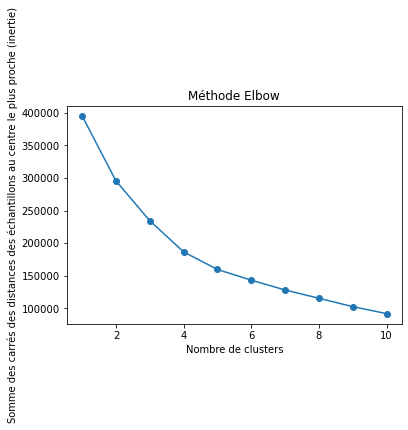

In [23]:

inertias = []

for n_clusters in range(1, 11):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_models)

    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel("Somme des carrés des distances des échantillons au centre le plus proche (inertie)")
plt.show()


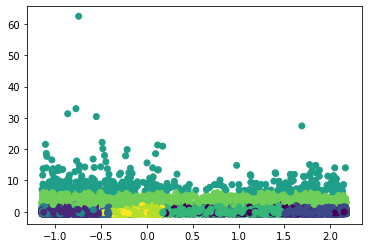

In [11]:
import matplotlib.pyplot as plt

# Entraîner le modèle KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_models)

# Obtenir les étiquettes de cluster pour chaque échantillon
labels = kmeans.predict(df_models)

# Afficher les clusters
plt.scatter(df_models['customer_zip_code_prefix'], df_models['payment_value'], c=labels)
plt.show()


In [35]:
df_models

customer_zip_code_prefix  payment_value  review_score  \
0                     -0.695215      -0.253545     -0.065190   
1                     -0.850245      -0.600010      0.677458   
2                     -1.140200      -0.408978      0.677458   
3                     -0.884312      -0.214479      0.677458   
4                     -0.740626      -0.118917      0.677458   
...                         ...            ...           ...   
99219                 -0.752239       0.663010      0.677458   
99220                 -1.023063       2.286642      0.677458   
99221                 -0.527699      -0.475830      0.677458   
99222                 -0.601170      -0.487388     -0.065190   
99223                 -0.584757       0.603139     -2.293136   

       customer_unique_id_infrequent_sklearn  customer_city_rio de janeiro  \
0                                        1.0                           0.0   
1                                        1.0                           0.0   
2                                        1.0                           0.0   
3                                        1.0                           0.0   
4                                        1.0                           0.0   
...                                      ...                           ...   
99219                                    1.0                           0.0   
99220                                    1.0                           0.0   
99221                                    1.0                           0.0   
99222                                    1.0                           0.0   
99223                                    1.0                           0.0   

       customer_city_sao paulo  customer_city_infrequent_sklearn  \
0                          0.0                               1.0   
1                          0.0                               1.0   
2                          1.0                               0.0   
3                          0.0                               1.0   
4                          0.0                               1.0   
...                        ...                               ...   
99219                      0.0                               1.0   
99220                      1.0                               0.0   
99221                      0.0                               1.0   
99222                      0.0                               1.0   
99223                      0.0                               1.0   

       customer_state_MG  customer_state_PR  customer_state_RJ  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99219                0.0                0.0                0.0   
99220                0.0                0.0                0.0   
99221                0.0                0.0                0.0   
99222                0.0                0.0                0.0   
99223                0.0                0.0                0.0   

       customer_state_RS  customer_state_SP  \
0                    0.0                1.0   
1                    0.0                1.0   
2                    0.0                1.0   
3                    0.0                1.0   
4                    0.0                1.0   
...                  ...                ...   
99219                0.0                1.0   
99220                0.0                1.0   
99221                0.0                1.0   
99222                0.0                1.0   
99223                0.0                1.0   

       customer_state_infrequent_sklearn  \
0                                    0.0   
1                                    0

In [15]:
## documentation dbscan
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3, min_samples=10).fit(df_models)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 57
Estimated number of noise points: 1186


In [22]:
##Ajout de silhouette score
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

db = DBSCAN(eps=0.5, min_samples=15).fit(df_models)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

if n_clusters_ > 1:  # Compute silhouette score only if there are more than one cluster
    silhouette_avg = silhouette_score(df_models, labels)
    print("Silhouette score:", silhouette_avg)
else:
    print("Silhouette score cannot be computed with only one cluster.")
    
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)





Silhouette score: 0.37334670468642445
Estimated number of clusters: 43
Estimated number of noise points: 916


In [25]:
n_clusters_

43

In [ ]:
from sklearn.manifold import TSNE

# Reducing dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(df_models)

# Plotting clusters with t-SNE
fig, ax = plt.subplots(figsize=(10, 8))
colors = db.labels_
ax.scatter(tsne_data[:, 0], tsne_data[:, 1], c=colors, cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('DBSCAN Clustering with t-SNE')
plt.show()


In [47]:
df_sampled = df_models.sample(n=50000,random_state=42)


In [ ]:
df_sampled

In [46]:
##trouver les meilleure paramètre eps et min_sample avec 50 000 lignes
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.1, 0.3, 0.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(df_models)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:  # Compute silhouette score only if there are more than one cluster
            silhouette_avg = silhouette_score(df_models, labels)
            print(f"eps={eps}, min_samples={min_samples}, Silhouette score:{silhouette_avg}")
        else:
            print("Silhouette score cannot be computed with only one cluster.")

        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)


eps=0.1, min_samples=5, Silhouette score:0.34868485274841365
Estimated number of clusters: 178
Estimated number of noise points: 2330
eps=0.1, min_samples=10, Silhouette score:0.3501211886305691
Estimated number of clusters: 94
Estimated number of noise points: 4112
eps=0.1, min_samples=15, Silhouette score:0.3495957393044335
Estimated number of clusters: 78
Estimated number of noise points: 5434
eps=0.3, min_samples=5, Silhouette score:0.35799660499700525
Estimated number of clusters: 89
Estimated number of noise points: 591
eps=0.3, min_samples=10, Silhouette score:0.3626273791079044
Estimated number of clusters: 57
Estimated number of noise points: 1186
eps=0.3, min_samples=15, Silhouette score:0.3706938982137576
Estimated number of clusters: 48
Estimated number of noise points: 1673
eps=0.5, min_samples=5, Silhouette score:0.3663185982374553
Estimated number of clusters: 61
Estimated number of noise points: 339
eps=0.5, min_samples=10, Silhouette score:0.36838633386536657
Estimated

In [48]:
##trouver les meilleure paramètre eps et min_sample avec toutes les données

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.1, 0.3, 0.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(df_sampled)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:  # Compute silhouette score only if there are more than one cluster
            silhouette_avg = silhouette_score(df_sampled, labels)
            print(f"eps={eps}, min_samples={min_samples}, Silhouette score:{silhouette_avg}")
        else:
            print("Silhouette score cannot be computed with only one cluster.")

        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)

eps=0.1, min_samples=5, Silhouette score:0.35063708703247015
Estimated number of clusters: 150
Estimated number of noise points: 1953
eps=0.1, min_samples=10, Silhouette score:0.34913925793142053
Estimated number of clusters: 78
Estimated number of noise points: 3290
eps=0.1, min_samples=15, Silhouette score:0.3489902783963144
Estimated number of clusters: 65
Estimated number of noise points: 4412
eps=0.3, min_samples=5, Silhouette score:0.36541686195547607
Estimated number of clusters: 84
Estimated number of noise points: 524
eps=0.3, min_samples=10, Silhouette score:0.37700633891753416
Estimated number of clusters: 50
Estimated number of noise points: 1001
eps=0.3, min_samples=15, Silhouette score:0.37810359208047595
Estimated number of clusters: 49
Estimated number of noise points: 1314
eps=0.5, min_samples=5, Silhouette score:0.369321723796596
Estimated number of clusters: 55
Estimated number of noise points: 285
eps=0.5, min_samples=10, Silhouette score:0.3780464861599709
Estimate

In [17]:
df_sampled = df_models.sample(n=20000,random_state=42)

In [14]:
X = df_models[['customer_zip_code_prefix', 'payment_value', 'review_score']]


In [11]:
df_models.columns

Index(['customer_zip_code_prefix', 'payment_value', 'review_score',
       'customer_unique_id_infrequent_sklearn', 'customer_city_rio de janeiro',
       'customer_city_sao paulo', 'customer_city_infrequent_sklearn',
       'customer_state_MG', 'customer_state_PR', 'customer_state_RJ',
       'customer_state_RS', 'customer_state_SP',
       'customer_state_infrequent_sklearn',
       'order_purchase_timestamp_infrequent_sklearn',
       'order_approved_at_infrequent_sklearn',
       'order_delivered_carrier_date_infrequent_sklearn',
       'order_delivered_customer_date_infrequent_sklearn',
       'order_estimated_delivery_date_infrequent_sklearn'],
      dtype='object')

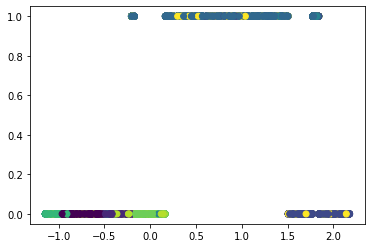

In [19]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


# définition du modèle de clustering hiérarchique
model = AgglomerativeClustering(n_clusters=10, linkage='ward').fit(df_sampled)


# visualisation des clusters
plt.scatter(df_sampled['customer_zip_code_prefix'], df_sampled['customer_state_infrequent_sklearn'], c=model.labels_, cmap='viridis')
plt.show()


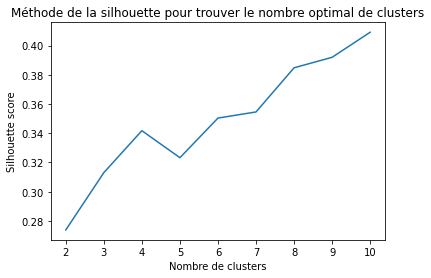

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Trouver le nombre optimal de clusters (k) en utilisant la méthode de la silhouette
silhouette_scores = []
for k in range(2, 11):
    linkage_matrix = linkage(df_sampled, method='ward')
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    if len(set(labels)) > 1:
        score = silhouette_score(df_sampled, labels)
        silhouette_scores.append((k, score))

# Afficher le graphique de la silhouette
plt.plot(*zip(*silhouette_scores))
plt.title('Méthode de la silhouette pour trouver le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette score')
plt.show()

# Déterminer le nombre optimal de clusters à partir du graphique de la silhouette
k_optimal = 10 # par exemple, si le score de silhouette est maximal à k=3

# En utilisant le nombre de clusters optimal déterminé précédemment
linkage_matrix = linkage(df_sampled, method='ward')
labels = fcluster(linkage_matrix, t=k_optimal, criterion='maxclust')


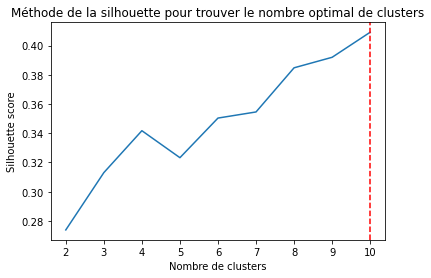

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Trouver le nombre optimal de clusters (k) en utilisant la méthode de la silhouette
silhouette_scores = []
for k in range(2, 11):
    linkage_matrix = linkage(df_sampled, method='ward')
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    if len(set(labels)) > 1:
        score = silhouette_score(df_sampled, labels)
        silhouette_scores.append((k, score))

# Déterminer le nombre optimal de clusters à partir du score de silhouette maximal
k_optimal = max(silhouette_scores, key=lambda x: x[1])[0]

# Afficher le graphique de la silhouette
plt.plot(*zip(*silhouette_scores))
plt.axvline(x=k_optimal, color='red', linestyle='--')
plt.title('Méthode de la silhouette pour trouver le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette score')
plt.show()

# Utiliser le nombre optimal de clusters déterminé précédemment pour le clustering hiérarchique
linkage_matrix = linkage(df_sampled, method='ward')
labels = fcluster(linkage_matrix, t=k_optimal, criterion='maxclust')
